<a href="https://colab.research.google.com/github/pachterlab/CWGFLHGCCHAP_2021/blob/master/notebooks/CellAtlasAnalysis/fullTrajAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!date

Mon Apr 12 18:25:46 UTC 2021


### **Download Data**

In [1]:
import requests
from tqdm import tnrange, tqdm_notebook
def download_file(doi,ext):
    url = 'https://api.datacite.org/dois/'+doi+'/media'
    r = requests.get(url).json()
    netcdf_url = r['data'][0]['attributes']['url']
    r = requests.get(netcdf_url,stream=True)
    #Set file name
    fname = doi.split('/')[-1]+ext
    #Download file with progress bar
    if r.status_code == 403:
        print("File Unavailable")
    if 'content-length' not in r.headers:
        print("Did not get file")
    else:
        with open(fname, 'wb') as f:
            total_length = int(r.headers.get('content-length'))
            pbar = tnrange(int(total_length/1024), unit="B")
            for chunk in r.iter_content(chunk_size=1024):
                if chunk:
                    pbar.update()
                    f.write(chunk)
        return fname

In [2]:
#Kallisto bus clustered starvation data, h5ad
download_file('10.22002/D1.1796','.gz')

#Starvation h5ad data, all nonzero genes included, filtered for 'real cells' from de-multiplexing
download_file('10.22002/D1.1797','.gz')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`


  0%|          | 0/479630 [00:00<?, ?B/s]

  0%|          | 0/26058 [00:00<?, ?B/s]

'D1.1797.gz'

In [3]:
#Previously saved neuron subpopulations
download_file('10.22002/D1.1804','.gz')

#Previously saved neuron pseudotime adata
download_file('10.22002/D1.1806','.gz')

#Previously saved nematocyte pseudotime adata
download_file('10.22002/D1.1805','.gz')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`


  0%|          | 0/1595 [00:00<?, ?B/s]

  0%|          | 0/10018 [00:00<?, ?B/s]

  0%|          | 0/14477 [00:00<?, ?B/s]

'D1.1805.gz'

In [4]:
#Human ortholog annotations
download_file('10.22002/D1.1819','.gz')

#Panther annotations
download_file('10.22002/D1.1820','.gz')

#GO Terms
download_file('10.22002/D1.1822','.gz')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`


  0%|          | 0/528 [00:00<?, ?B/s]

  0%|          | 0/515 [00:00<?, ?B/s]

  0%|          | 0/227 [00:00<?, ?B/s]

'D1.1822.gz'

In [5]:
#Previously saved ranked pseudotime genes

#Nematocyte trajectory (ranked genes)
#!wget --quiet https://caltech.box.com/shared/static/u19vzppejvt6ky3ysqptt2ia2dqozpkf
download_file('10.22002/D1.1808','.gz')

#Neuron trajectory (ranked genes)
#!wget --quiet https://caltech.box.com/shared/static/ippfug3xt20etmyx08egzpipgmyfc17m
download_file('10.22002/D1.1807','.gz')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`


  0%|          | 0/144 [00:00<?, ?B/s]

  0%|          | 0/127 [00:00<?, ?B/s]

'D1.1807.gz'

In [6]:
!gunzip *.gz

In [7]:
#Install packages
!pip install --quiet anndata
!pip install --quiet scanpy==1.7.0rc1

!pip install --quiet louvain
#!pip install --quiet cellrank==1.3.0

     |████████████████████████████████| 91 kB 3.9 MB/s 
     |████████████████████████████████| 10.2 MB 5.6 MB/s 
     |████████████████████████████████| 69 kB 6.4 MB/s 
     |████████████████████████████████| 63 kB 1.9 MB/s 
     |████████████████████████████████| 2.1 MB 5.6 MB/s 
     |████████████████████████████████| 3.2 MB 17.4 MB/s 


In [8]:
!pip3 install --quiet rpy2

###**Import Packages** 

In [9]:
#Import Packages

import random
import pandas as pd
import anndata
import scanpy as sc
import numpy as np
import scipy.sparse
#import cellrank as cr

import warnings
warnings.filterwarnings('ignore')

from sklearn.neighbors import (KNeighborsClassifier,NeighborhoodComponentsAnalysis)
from sklearn.pipeline import Pipeline
from sklearn.manifold import TSNE
from scipy import sparse, io
#import scrublet as scr

import matplotlib.pyplot as plt
import matplotlib
matplotlib.rc('axes',edgecolor='black')
%matplotlib inline
#sc.set_figure_params(dpi=125)

import seaborn as sns
sns.set(style="whitegrid")
%load_ext rpy2.ipython

In [10]:
#Read in annotations
from io import StringIO

hg_ortho_df = pd.read_csv(StringIO(''.join(l.replace('|', '\t') for l in open('D1.1819'))),
            sep="\t",header=None,skiprows=[0,1,2,3])

hg_ortho_df[['XLOC','TCONS']] = hg_ortho_df[13].str.split(expand=True) 
hg_ortho_df[['Gene','gi']] = hg_ortho_df[3].str.split(expand=True) 
hg_ortho_df['Description']= hg_ortho_df[11]


panther_df = pd.read_csv('D1.1820',
            sep="\t",header=None) #skiprows=[0,1,2,3]



goTerm_df = pd.read_csv('D1.1822',
            sep=" ",header=None) #skiprows=[0,1,2,3]

In [11]:
#Read in saved data
bus_fs_combo = anndata.read('D1.1796')
print(bus_fs_combo)

bus_fs_raw  = anndata.read('D1.1797')
bus_fs_raw.obs['cellRanger_louvain'] = pd.Categorical(bus_fs_combo.obs['cellRanger_louvain'])
bus_fs_raw.obs['fed'] = pd.Categorical(bus_fs_combo.obs['fed'])
bus_fs_raw.obs['orgID'] = pd.Categorical(bus_fs_combo.obs['orgID'])
bus_fs_raw.obs['annos'] = pd.Categorical(bus_fs_combo.obs['annos'])
bus_fs_raw.obs['annosSub'] = pd.Categorical(bus_fs_combo.obs['annosSub'])

bus_fs_raw.uns['annos_colors'] = bus_fs_combo.uns['annos_colors']
bus_fs_raw.uns['cellRanger_louvain_colors'] = bus_fs_combo.uns['annosSub_colors']
#bus_fs_raw.uns['annosSub_colors'] = bus_fs_combo.uns['annosSub_colors']
print(bus_fs_raw)

neuron_subpops  = anndata.read('D1.1804') 
print(neuron_subpops)


AnnData object with n_obs × n_vars = 13673 × 8696
    obs: 'batch', 'n_counts', 'n_countslog', 'louvain', 'leiden', 'orgID', 'fed', 'starved', 'fed_neighbor_score', 'cellRanger_louvain', 'annos', 'new_cellRanger_louvain', 'annosSub'
    var: 'n_counts', 'mean', 'std'
    uns: 'annosSub_colors', 'annos_colors', 'cellRanger_louvain_colors', 'cellRanger_louvain_sizes', "dendrogram_['new_cellRanger_louvain']", 'dendrogram_new_cellRanger_louvain', 'fed_colors', 'fed_neighbor_score_colors', 'leiden', 'leiden_colors', 'louvain', 'louvain_colors', 'neighbors', 'new_cellRanger_louvain_colors', 'orgID_colors', 'paga', 'pca', 'rank_genes_groups', 'umap'
    obsm: 'X_nca', 'X_pca', 'X_tsne', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'
AnnData object with n_obs × n_vars = 13673 × 46716
    obs: 'batch', 'cellRanger_louvain', 'fed', 'orgID', 'annos', 'annosSub'
    uns: 'annos_colors', 'cellRanger_louvain_colors'
AnnData object with n_obs × n_vars = 1387 × 2000
    obs: 'batch',

In [12]:
#Functions used

#Random forest regression to determine best genes to predict pseudotime
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
def runRegr_dptPseudotime(adata,adata_scaled,label='dpt_pseudotime'):
  X = adata.X
  if scipy.sparse.issparse(X):
    X = X.toarray()
  
  #80% training data
  perc = 0.8
  n = np.int(perc*X.shape[0])

  np.random.seed(0)
  indices = np.random.choice(X.shape[0], n, replace=False,)
  X_train = X[indices,:]

  y = adata_scaled.obs[label]
  y_train = y[indices]

  X_test = X[[i for i in range(0,X.shape[0]) if i not in indices],:]
  y_test = y[[i for i in range(0,X.shape[0]) if i not in indices]]

  regr = RandomForestRegressor(random_state=42,max_samples=perc)
  regr.fit(X_train, y_train)
  print(regr.score(X_test, y_test))
  result = permutation_importance(regr, X_test, y_test, n_repeats=5, random_state=42)
  
  return result

#Convert filtered results to dataframe
def resToDF(result,adata):
  neur_gene_res = pd.DataFrame()
  neur_gene_res['Genes'] = adata.var_names
  neur_gene_res['Mean'] = result.importances_mean
  neur_gene_res['Std'] = result.importances_std

  neur_gene_res= neur_gene_res.sort_values('Mean', axis=0, ascending=False)

  neur_gene_res= neur_gene_res[neur_gene_res.Mean > 0]

  print(len(neur_gene_res.Genes))

  return neur_gene_res

#Make dataframe, with 100 marker genes for each cluster + annotations
def annotateResDF(resultDF):
  orthoGene = []
  orthoDescr = []

  pantherNum = []
  pantherDescr = []

  goTerms = []

  genes = resultDF.Genes

  for g in genes:
          
    sub_df = hg_ortho_df[hg_ortho_df.XLOC.isin([g])]
    panth_df = panther_df[panther_df[0].isin([g])]
    go_df = goTerm_df[goTerm_df[0].isin([g])]

    if len(sub_df) > 0:
      #Save first result for gene/description
      orthoGene += [list(sub_df.Gene)[0]]
      orthoDescr += [list(sub_df.Description)[0]]
    else:
      orthoGene += ['NA']
      orthoDescr += ['NA']


    if len(panth_df) > 0:
      pantherNum += [list(panth_df[1])]
      pantherDescr += [list(panth_df[2])]
    else:
      pantherNum += ['NA']
      pantherDescr += ['NA']


    if len(go_df) > 0:
      goTerms += [list(go_df[1])]
    else:
      goTerms += ['NA']
  

  resultDF['orthoGene'] = orthoGene
  resultDF['orthoDescr'] = orthoDescr

  resultDF['pantherID'] = pantherNum
  resultDF['pantherDescr'] = pantherDescr

  resultDF['goTerms'] = goTerms
      
  return resultDF
  #list(neurons.uns['rank_genes_groups']['names']['1'])

#Order cells in cell-by-gene matrix by pseudotime
def orderTime(adata):
  sortTime = np.argsort(adata.obs['dpt_pseudotime'])
  newNames = adata.obs_names[list(sortTime)]

  adataRet = adata[newNames,:]
  return adataRet


In [13]:
#Order cells by nematocyte cluster (based on prior literature)

def orderTimeClus(adata,clus = [0,12,11,23,17,10,5,21]):
  names = []
  for i in clus:
    sub = adata[adata.obs['cellRanger_louvain'].isin([i])]
    # sortTime = np.argsort(sub.obs['dpt_pseudotime'])
    # names += list(sub.obs_names[list(sortTime)])
    names += list(sub.obs_names)
  #newNames = adata.obs_names[list(sortTime)]

  adataRet = adata[names,:]
  return adataRet

### **Check gland cell trajectories and/or hair cells**

#### **Save gene count matrices for reading into R**

In [ ]:
#Nematocytes: 11,12,17,23
#Hair cells: 5,10,21
#Gland cells: 27,25,32,34,22
#Neurons: 31,26,6,9
#i-cells:0

# full_lin = bus_fs_raw[bus_fs_raw.obs['cellRanger_louvain'].isin([5,10,21,0,11,12,17,23,27,25,32,34,22])]

#Not including nematocytes here
full_lin = bus_fs_raw[bus_fs_raw.obs['cellRanger_louvain'].isin([31,26,6,9,0,27,25,32,34,22])]
full_lin


View of AnnData object with n_obs × n_vars = 3296 × 46716
    obs: 'batch', 'cellRanger_louvain', 'fed', 'orgID', 'annos', 'annosSub'
    uns: 'annos_colors', 'cellRanger_louvain_colors'

In [ ]:
io.mmwrite('allLineage.mtx', full_lin.X)

In [ ]:
meta = pd.DataFrame()
meta['cluster'] = full_lin.obs['cellRanger_louvain']
meta['name'] = full_lin.obs['annosSub']
meta['fed'] = full_lin.obs['fed']
meta.head()

cluster                     name    fed
index                                                     
AAACCTGCAAAGTGCG-1       6  Developing Neural Cells  False
AAACCTGCAATCACAC-1       9           Neural Cells-A  False
AAACCTGGTGCAGTAG-1       9           Neural Cells-A   True
AAACCTGTCGGATGGA-1       0                  i-Cells   True
AAACGGGAGTGAACAT-1       6  Developing Neural Cells   True

In [ ]:
meta.to_csv('allLinMeta.csv')

In [ ]:
genes = pd.DataFrame()
genes['genes'] = full_lin.var_names

genes.to_csv('genes.csv',index=None)


Lineage with Neurons

In [ ]:
#Check all cells + neurons (31,26,6,9)
neur_lin = bus_fs_raw[bus_fs_raw.obs['cellRanger_louvain'].isin([31,26,6,9,0,27,25,32,34,22,5,10,21,11,12,17,23])]
neur_lin

#io.mmwrite('neurLineage.mtx', neur_lin.X)



View of AnnData object with n_obs × n_vars = 6115 × 46716
    obs: 'batch', 'cellRanger_louvain', 'fed', 'orgID', 'annos', 'annosSub'
    uns: 'annos_colors', 'cellRanger_louvain_colors'

In [ ]:
io.mmwrite('neurLineage.mtx', neur_lin.X)

meta = pd.DataFrame()
meta['cluster'] = neur_lin.obs['cellRanger_louvain']
meta['name'] = neur_lin.obs['annosSub']
meta['fed'] = neur_lin.obs['fed']
meta.to_csv('neurLinMeta.csv')

In [ ]:
genes = pd.DataFrame()
genes['genes'] = neur_lin.var_names

genes.to_csv('neurGenes.csv',index=None)

Control test with outgroup i-cell derived cell type (medium oocytes, 2)

In [ ]:
#Check all cells + neurons (31,26,6,9)
control_lin = bus_fs_raw[bus_fs_raw.obs['cellRanger_louvain'].isin([31,26,6,9,0,27,25,32,34,22,5,10,21,11,12,17,23,2])]
control_lin

io.mmwrite('controlLineage.mtx', control_lin.X)

meta = pd.DataFrame()
meta['cluster'] = control_lin.obs['cellRanger_louvain']
meta['name'] = control_lin.obs['annosSub']
meta['fed'] = control_lin.obs['fed']
meta.to_csv('controlLinMeta.csv')

In [ ]:
genes = pd.DataFrame()
genes['genes'] = control_lin.var_names

genes.to_csv('controlGenes.csv',index=None)

#### **R URD Analysis**

In [ ]:
# %%R
# #Set up R environment
# install.packages("BiocManager")
# BiocManager::install(version = "3.10")

In [ ]:
!sudo apt-get update
!sudo apt-get install libxml2-dev
!sudo apt-get install r-cran-xml
!sudo apt-get install libcurl4-openssl-dev

Get:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:3 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:4 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ Packages [60.9 kB]
Hit:5 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:6 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Ign:7 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:8 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release [697 B]
Hit:9 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:10 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release.gpg [836 B]
Get:11 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Ign:13 https://developer.download.nvi

In [ ]:
%%R
install.packages("rgl",repos = "http://cran.us.r-project.org")
# Load packages
suppressPackageStartupMessages(library(rgl))

R[write to console]: Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

R[write to console]: also installing the dependencies ‘sass’, ‘jquerylib’, ‘httpuv’, ‘xtable’, ‘sourcetools’, ‘later’, ‘promises’, ‘bslib’, ‘lazyeval’, ‘miniUI’, ‘webshot’, ‘shinyjs’, ‘htmlwidgets’, ‘shiny’, ‘crosstalk’, ‘manipulateWidget’


R[write to console]: trying URL 'http://cran.us.r-project.org/src/contrib/sass_0.4.0.tar.gz'

R[write to console]: Content type 'application/x-gzip'
R[write to console]:  length 3022459 bytes (2.9 MB)

R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to cons

In [ ]:
%%R
if (as.numeric(R.version$major) <= 3 && as.numeric(R.version$minor) < 5) {
  # R < 3.5
  message("Loading Bioconductor (biocLite) to install required packages.")
  source("https://bioconductor.org/biocLite.R")
  message("Installing required packages from Bioconductor.")
  biocLite(c('Biobase', 'S4Vectors', 'AnnotationDbi', 'destiny'), suppressUpdates=T)
} else {
  # R >= 3.5
  if (!requireNamespace("BiocManager", quietly = TRUE)) {
    message("Installing biocManager to install required Bioconductor packages.")
    install.packages("BiocManager")
  }
  message("Installing required packages from Bioconductor (BiocManager).")
  BiocManager::install(c('Biobase', 'S4Vectors', 'AnnotationDbi', 'destiny'), suppressUpdates=T)
}

# Check that Bioconductor installation went smoothly.
if (!requireNamespace("Biobase", quietly = TRUE)) {stop("Failed to install required package 'Biobase' from Bioconductor.")}
if (!requireNamespace("S4Vectors", quietly = TRUE)) {stop("Failed to install required package 'S4Vectors' from Bioconductor.")}
if (!requireNamespace("AnnotationDbi", quietly = TRUE)) {stop("Failed to install required package 'AnnotationDbi' from Bioconductor.")}
if (!requireNamespace("destiny", quietly = TRUE)) {stop("Failed to install required package 'destiny' from Bioconductor.")}

# Install URD (and devtools, if necessary)
if (requireNamespace("devtools", quietly = TRUE)) {
  message("Installing URD")
  devtools::install_github(repo="farrellja/URD")
} else {
  message("Installing devtools")
  install.packages("devtools")
  message("Installing URD")
  devtools::install_github(repo="farrellja/URD")
}

# Check that URD installed.
if (requireNamespace("URD", quietly = TRUE)) {
  message("URD installed successfully!")
  message('You can load it by typing: library("URD")')
  message('Try "?URD" for starting tips.')
} else {
  message("Something went wrong. It doesn't seem that URD installed correctly.")
}

R[write to console]: Installing required packages from Bioconductor (BiocManager).

R[write to console]: 'getOption("repos")' replaces Bioconductor standard repositories, see
'?repositories' for details

replacement repositories:
    CRAN: https://cran.rstudio.com


R[write to console]: Bioconductor version 3.12 (BiocManager 1.30.15), R 4.0.5 (2021-03-31)

R[write to console]: Old packages: 'IRkernel', 'cachem', 'devtools', 'dplyr', 'fansi', 'hms',
  'openssl', 'pillar', 'rmarkdown', 'rversions', 'stringi', 'systemfonts',
  'tibble', 'tinytex', 'xfun', 'zip', 'Matrix', 'mgcv'



Update all/some/none? [a/s/n]: a


R[write to console]: trying URL 'https://cran.rstudio.com/src/contrib/IRkernel_1.2.tar.gz'

R[write to console]: Content type 'application/x-gzip'
R[write to console]:  length 62663 bytes (61 KB)

R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: 

✔  checking for file ‘/tmp/RtmpMYCr4q/remotes3b77768e17/farrellja-URD-0fed8b8/DESCRIPTION’ (341ms)
─  preparing ‘URD’:
✔  checking DESCRIPTION meta-information
─  checking for LF line-endings in source and make files and shell scripts
─  checking for empty or unneeded directories
─  building ‘URD_1.1.1.tar.gz’
   Warning in utils::tar(filepath, pkgname, compression = compression, compression_level = 9L,  :
     storing paths of more than 100 bytes is not portable:
     ‘URD/Analyses/QuickStart/URD-QuickStart-AxialMesoderm_files/figure-markdown_github/unnamed-chunk-10-1.png’
   Warning in utils::tar(filepath, pkgname, compression = compression, compression_level = 9L,  :
     storing paths of more than 100 bytes is not portable:
     ‘URD/Analyses/QuickStart/URD-QuickStart-AxialMesoderm_files/figure-markdown_github/unnamed-chunk-11-1.png’
   Warning in utils::tar(filepath, pkgname, compression = compression, compression_level = 9L,  :
     storing paths of more than 100 bytes is not por

R[write to console]: Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

R[write to console]: Registered S3 method overwritten by 'gplots':
  method         from 
  reorder.factor gdata

R[write to console]: URD installed successfully!

R[write to console]: You can load it by typing: library("URD")

R[write to console]: Try "?URD" for starting tips.



In [ ]:
%%R 
suppressPackageStartupMessages(library(URD))
#install.packages("Matrix")
suppressPackageStartupMessages(library(Matrix))

##### **No Nematocyte Lineage** (Gland cells and Neural Cells)

In [ ]:
%%R 

fullDF <- t(as.matrix(readMM("allLineage.mtx")))

genes <- read.table("genes.csv", header = TRUE, sep = ",")
meta <- read.table("allLinMeta.csv", header = TRUE, sep = ",")

rownames(fullDF) <- genes$genes
colnames(fullDF) <- meta$index

rownames(meta) <- meta$index

head(meta)

                                index cluster                    name   fed
AAACCTGCAAAGTGCG-1 AAACCTGCAAAGTGCG-1       6 Developing Neural Cells False
AAACCTGCAATCACAC-1 AAACCTGCAATCACAC-1       9          Neural Cells-A False
AAACCTGGTGCAGTAG-1 AAACCTGGTGCAGTAG-1       9          Neural Cells-A  True
AAACCTGTCGGATGGA-1 AAACCTGTCGGATGGA-1       0                 i-Cells  True
AAACGGGAGTGAACAT-1 AAACGGGAGTGAACAT-1       6 Developing Neural Cells  True
AAACGGGCAAACCCAT-1 AAACGGGCAAACCCAT-1       0                 i-Cells False


In [ ]:
%%R
#Test removing unknown cluster 17
subMeta <- meta[meta$cluster != 17,]  
subDF <- fullDF[,subMeta$index]

head(subMeta)

                                index cluster                    name   fed
AAACCTGCAAAGTGCG-1 AAACCTGCAAAGTGCG-1       6 Developing Neural Cells False
AAACCTGCAATCACAC-1 AAACCTGCAATCACAC-1       9          Neural Cells-A False
AAACCTGGTGCAGTAG-1 AAACCTGGTGCAGTAG-1       9          Neural Cells-A  True
AAACCTGTCGGATGGA-1 AAACCTGTCGGATGGA-1       0                 i-Cells  True
AAACGGGAGTGAACAT-1 AAACGGGAGTGAACAT-1       6 Developing Neural Cells  True
AAACGGGCAAACCCAT-1 AAACGGGCAAACCCAT-1       0                 i-Cells False


In [ ]:
%%R
knitr::opts_chunk$set(echo = TRUE)
rgl::setupKnitr()

In [ ]:
%%R
# Create an URD object, which will filter the data, then normalize and log-transform it.
lin <- createURD(count.data = fullDF, meta = meta, min.cells=3, min.counts=3)
lin

R[write to console]: 2021-06-01 16:46:16: Filtering cells by number of genes.

R[write to console]: 2021-06-01 16:46:27: Filtering genes by number of cells.

R[write to console]: 2021-06-01 16:46:36: Filtering genes by number of counts across entire data.

R[write to console]: 2021-06-01 16:46:42: Filtering genes by maximum observed expression.

R[write to console]: 2021-06-01 16:46:49: Creating URD object.

R[write to console]: 2021-06-01 16:46:50: Determining normalization factors.

R[write to console]: 2021-06-01 16:46:52: Normalizing and log-transforming the data.

R[write to console]: 2021-06-01 16:46:58: Finishing setup of the URD object.

R[write to console]: 2021-06-01 16:46:59: All done.



URD object: 15514 genes x 2518 cells.


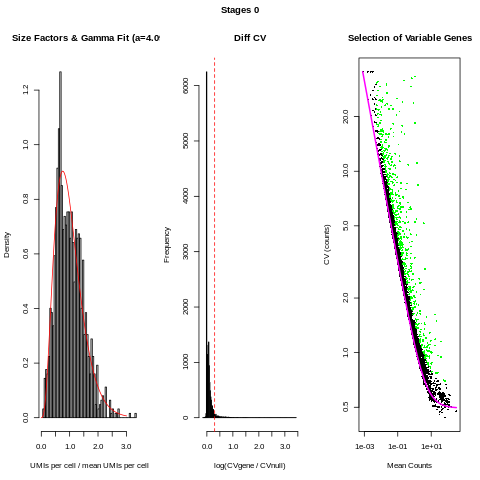

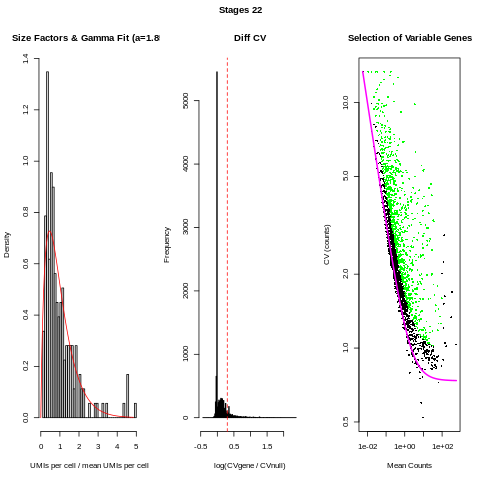

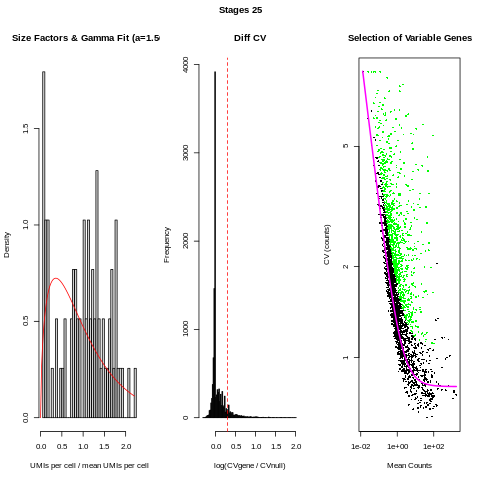

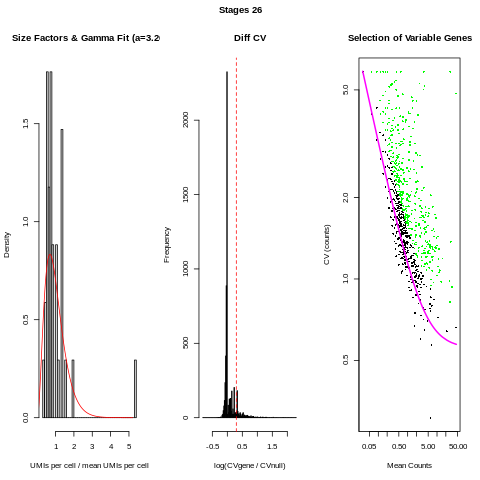

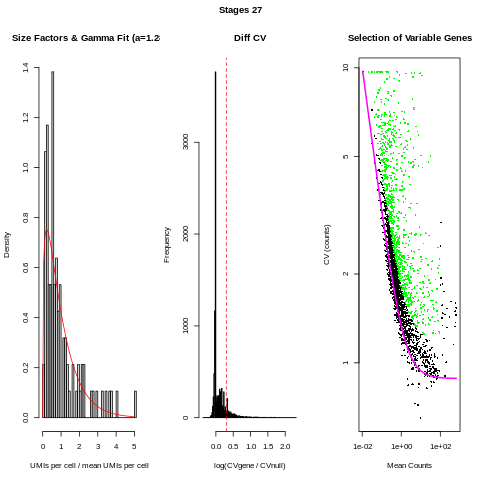

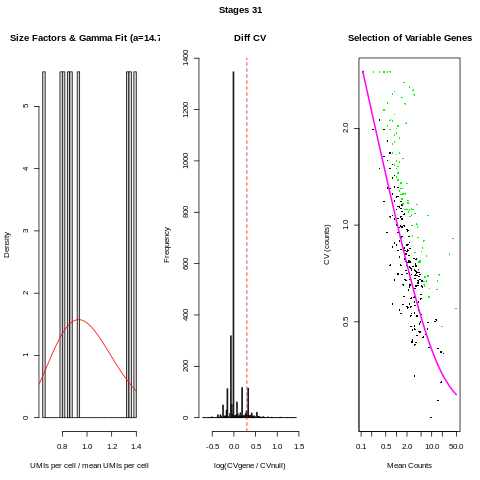

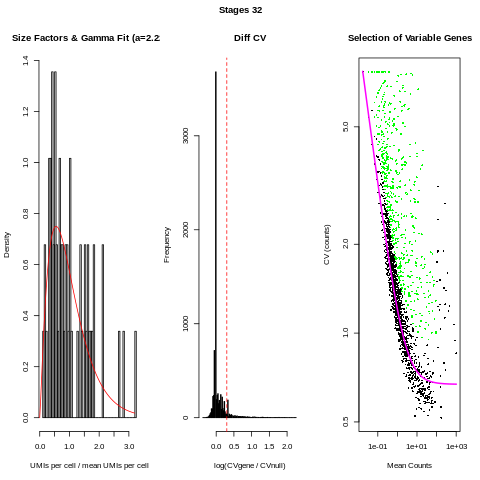

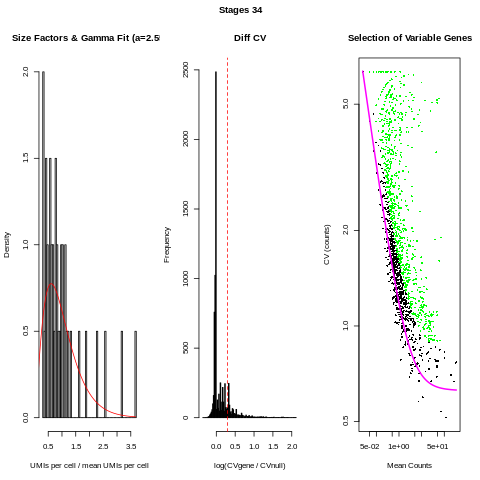

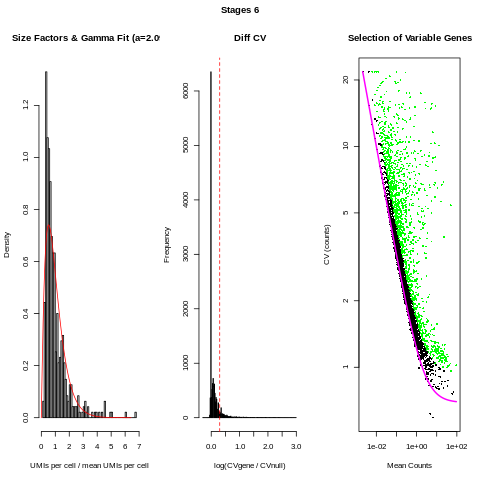

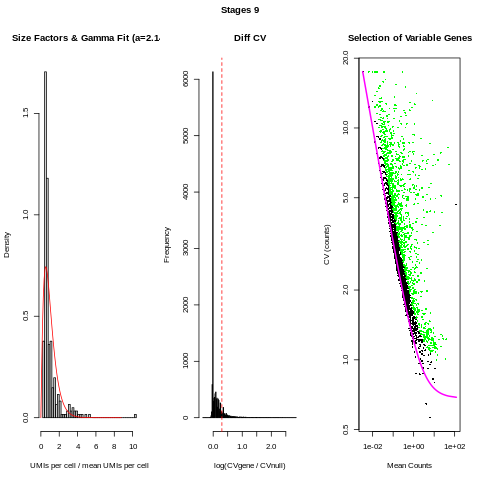

In [ ]:
%%R
# Copy stage from @meta to @group.ids 
lin@group.ids$stage <- as.character(lin@meta[rownames(lin@group.ids),"cluster"])

# Get variable genes for each group of stages
# diffCV.cutoff can be varied to include more or fewer genes.
stages <- sort(unique(lin@group.ids$stage))
var.by.stage <- lapply(seq(length(stages)), function(n) {
  findVariableGenes(lin, cells.fit=cellsInCluster(lin, "stage", stages[n]), set.object.var.genes=F, diffCV.cutoff=0.3, mean.min=.005, mean.max=100, main.use=paste0("Stages ", stages[n]), do.plot=T)
})

In [ ]:
%%R
# Combine the results from each group of stages into a single list of variable genes and load into the URD object
var.genes <- sort(unique(unlist(var.by.stage)))
lin@var.genes <- var.genes

[1] "2021-06-01 16:47:09: Centering and scaling data."
[1] "2021-06-01 16:47:11: Removing genes with no variation."
[1] "2021-06-01 16:47:11: Calculating PCA."
[1] "2021-06-01 16:47:41: Estimating significant PCs."
[1] "Marchenko-Pastur eigenvalue null upper bound: 5.34930159805564"
[1] "28 PCs have eigenvalues larger than 2 times null upper bound."
[1] "Storing 56 PCs."


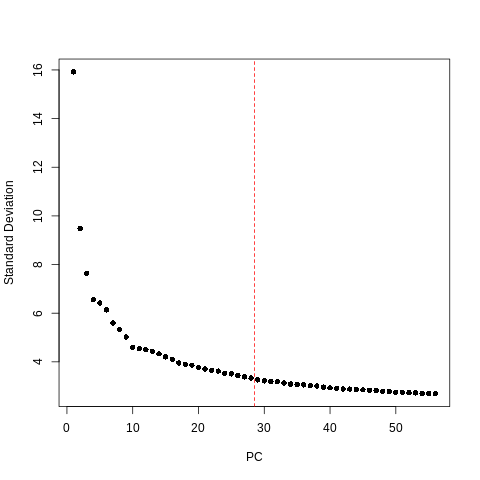

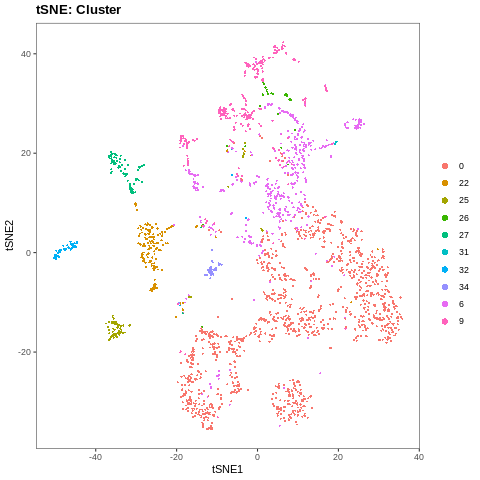

In [ ]:
%%R
# Calculate PCA and consider those PCs that with standard deviation 2x expected by noise as significant
lin <- calcPCA(lin, mp.factor = 2)
pcSDPlot(lin)

# Calculate tSNE
set.seed(42)
lin <- calcTsne(object = lin)
plotDim(lin, "name", plot.title = "tSNE: Cell Type")
plotDim(lin, "stage", plot.title = "tSNE: Cluster")

[1] "destiny determined an optimal global sigma of 25.893"


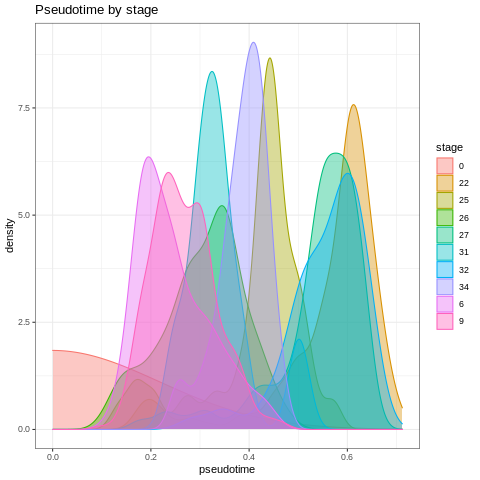

In [ ]:
%%R
# In this case, knn=100 (larger than sqrt(n.cells)) works well because there are not many cell types.
# Sigma 16 is slightly smaller than the sigma auto-determined by using NULL parameter.
lin <- calcDM(lin, knn = 60)
# Here we use all cells from the first stage as the root
root.cells <- cellsInCluster(lin, "stage", "0")

# Then we run 'flood' simulations
lin.floods <- floodPseudotime(lin, root.cells = root.cells, n=50, minimum.cells.flooded = 2, verbose=F)

# The we process the simulations into a pseudotime
lin <- floodPseudotimeProcess(lin, lin.floods, floods.name="pseudotime")

pseudotimePlotStabilityOverall(lin)

plotDists(lin, "pseudotime", "stage", plot.title="Pseudotime by stage")

In [ ]:
%%R
sort(unique(lin@group.ids$stage))

 [1] "0"  "22" "25" "26" "27" "31" "32" "34" "6"  "9" 


[1] "2021-06-01 17:06:38: Centering and scaling data."
[1] "2021-06-01 17:06:38: Removing genes with no variation."
[1] "2021-06-01 17:06:39: Calculating PCA."
[1] "2021-06-01 17:06:41: Estimating significant PCs."
[1] "Marchenko-Pastur eigenvalue null upper bound: 11.0838190618371"
[1] "25 PCs have eigenvalues larger than 1.5 times null upper bound."
[1] "Storing 50 PCs."


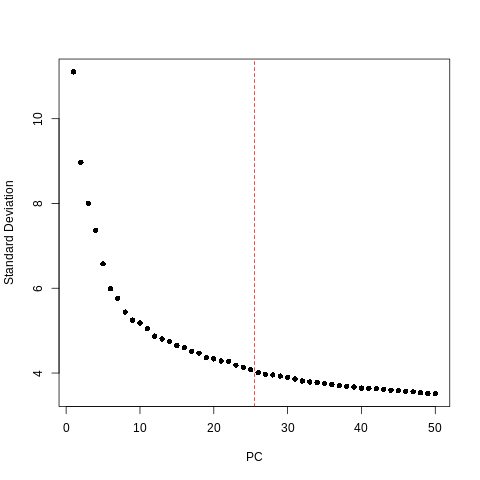

In [ ]:
%%R
# Create a subsetted object of just those cells from the final stage
lin.tips <- urdSubset(lin, cells.keep=cellsInCluster(lin, "stage",  c(9,26,31,27,25,32,34,22)))

# Use the variable genes that were calculated only on the final group of stages (which
# contain the last stage).
#lin.tips@var.genes <- sort(unique(unlist(var.by.stage[c(2,3,4,5,6,7,8,10)])))

# Calculate PCA and tSNE
lin.tips <- calcPCA(lin.tips, mp.factor = 1.5)
pcSDPlot(lin.tips)

[1] "Mean pseudotime back (~40 cells) 0.0106395048641373"
[1] "Chance of accepted move to equal pseudotime is 0.99009900990099"
[1] "Mean pseudotime forward (~0 cells) 0"


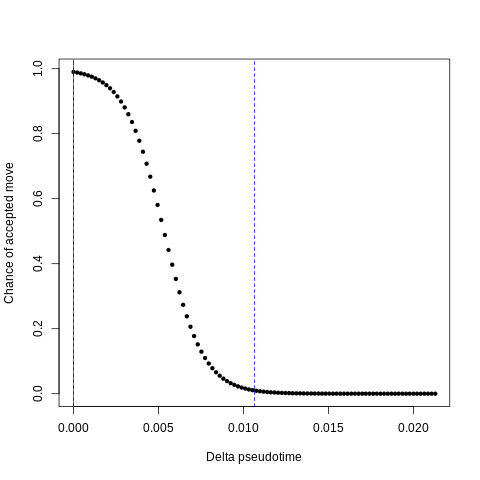

In [ ]:
%%R
# Calculate graph clustering of these cells
lin.tips <- graphClustering(lin.tips, num.nn = 50, do.jaccard=T, method="Louvain")

# Copy cluster identities from axial.6somite object to a new clustering ("tip.clusters") in the full axial object.
lin@group.ids[rownames(lin.tips@group.ids), "tip.clusters"] <- lin.tips@group.ids$stage

# Determine the parameters of the logistic used to bias the transition probabilities. The procedure
# is relatively robust to this parameter, but the cell numbers may need to be modified for larger
# or smaller data sets.
lin.ptlogistic <- pseudotimeDetermineLogistic(lin, "pseudotime", optimal.cells.forward=0, max.cells.back=40, do.plot = T)

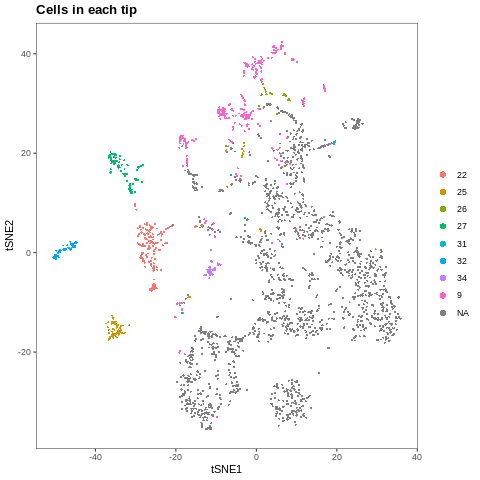

In [ ]:
%%R
# Bias the transition matrix acording to pseudotime
lin.biased.tm <- as.matrix(pseudotimeWeightTransitionMatrix(lin, "pseudotime", logistic.params=lin.ptlogistic))

# Simulate the biased random walks from each tip
lin.walks <- simulateRandomWalksFromTips(lin, tip.group.id="tip.clusters", root.cells=root.cells, transition.matrix = lin.biased.tm, n.per.tip = 25000, root.visits = 1, max.steps = 5000, verbose = F)

# Process the biased random walks into visitation frequencies
lin <- processRandomWalksFromTips(lin, lin.walks, verbose = F)

#Plot tips
plotDim(lin, "tip.clusters", plot.title="Cells in each tip")


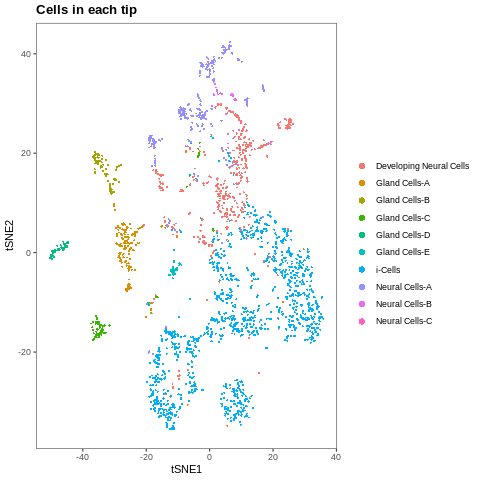

In [ ]:
%%R
plotDim(lin, "name", plot.title="Cells in each tip")

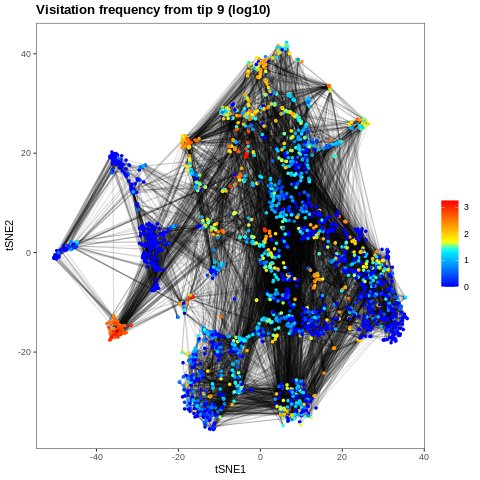

In [ ]:
%%R
#Plot visitation frequencies from tips
plotDim(lin, "visitfreq.log.25", plot.title="Visitation frequency from tip 9 (log10)", transitions.plot=10000)



In [ ]:
%%R
# Load the cells used for each tip into the URD object
lin.tree <- loadTipCells(lin, "tip.clusters")

# # Combine the two small clusters in a single population into one tip
# lin.tree <- combineTipVisitation(lin.tree, "16", "5", new.tip = "16")

# Build the tree,  c(10,21,17,23,27,25,32,34,22) = tips
lin.tree <- buildTree(lin.tree, pseudotime = "pseudotime", tips.use=c("9","26","31","27","25","32","22") , divergence.method = "preference", cells.per.pseudotime.bin = 15, bins.per.pseudotime.window = 10, save.all.breakpoint.info = T, p.thresh=0.01,min.cells.per.segment=10)

[1] "Calculating divergence between 9 and 26 (Pseudotime 0 to 0.462)"
[1] "Calculating divergence between 9 and 31 (Pseudotime 0 to 0.468)"
[1] "Calculating divergence between 9 and 27 (Pseudotime 0 to 0.468)"


R[write to console]: Difference between 9 and 27 always TRUE -- setting breakpoint to beginning.



[1] "Calculating divergence between 9 and 25 (Pseudotime 0 to 0.468)"
[1] "Calculating divergence between 9 and 32 (Pseudotime 0 to 0.468)"
[1] "Calculating divergence between 9 and 22 (Pseudotime 0 to 0.468)"
[1] "Calculating divergence between 26 and 31 (Pseudotime 0 to 0.462)"
[1] "Calculating divergence between 26 and 27 (Pseudotime 0 to 0.462)"


R[write to console]: Difference between 26 and 27 always TRUE -- setting breakpoint to beginning.



[1] "Calculating divergence between 26 and 25 (Pseudotime 0 to 0.462)"
[1] "Calculating divergence between 26 and 32 (Pseudotime 0 to 0.462)"
[1] "Calculating divergence between 26 and 22 (Pseudotime 0 to 0.462)"
[1] "Calculating divergence between 31 and 27 (Pseudotime 0 to 0.502)"


R[write to console]: Difference between 31 and 27 always TRUE -- setting breakpoint to beginning.



[1] "Calculating divergence between 31 and 25 (Pseudotime 0 to 0.502)"
[1] "Calculating divergence between 31 and 32 (Pseudotime 0 to 0.502)"
[1] "Calculating divergence between 31 and 22 (Pseudotime 0 to 0.502)"
[1] "Calculating divergence between 27 and 25 (Pseudotime 0 to 0.574)"


R[write to console]: Difference between 27 and 25 always TRUE -- setting breakpoint to beginning.



[1] "Calculating divergence between 27 and 32 (Pseudotime 0 to 0.644)"
[1] "Calculating divergence between 27 and 22 (Pseudotime 0 to 0.644)"
[1] "Calculating divergence between 25 and 32 (Pseudotime 0 to 0.574)"
[1] "Calculating divergence between 25 and 22 (Pseudotime 0 to 0.574)"
[1] "Calculating divergence between 32 and 22 (Pseudotime 0 to 0.653)"
[1] "Joining segments 27 and 22 at pseudotime 0.44 to create segment 33"
[1] "Calculating divergence between 9 and 33 (Pseudotime 0 to 0.44)"
[1] "Calculating divergence between 26 and 33 (Pseudotime 0 to 0.44)"
[1] "Calculating divergence between 31 and 33 (Pseudotime 0 to 0.44)"
[1] "Calculating divergence between 25 and 33 (Pseudotime 0 to 0.44)"
[1] "Calculating divergence between 32 and 33 (Pseudotime 0 to 0.44)"


R[write to console]: Difference between 32 and 33 always FALSE -- setting breakpoint to end.



[1] "Joining segments 32 and 33 at pseudotime 0.438 to create segment 34"
[1] "Calculating divergence between 9 and 34 (Pseudotime 0 to 0.438)"
[1] "Calculating divergence between 26 and 34 (Pseudotime 0 to 0.438)"
[1] "Calculating divergence between 31 and 34 (Pseudotime 0 to 0.438)"
[1] "Calculating divergence between 25 and 34 (Pseudotime 0 to 0.438)"
[1] "Joining segments 26 and 31 at pseudotime 0.263 to create segment 35"
[1] "Calculating divergence between 9 and 35 (Pseudotime 0 to 0.263)"
[1] "Calculating divergence between 25 and 35 (Pseudotime 0 to 0.263)"
[1] "Calculating divergence between 34 and 35 (Pseudotime 0 to 0.263)"
[1] "Joining segments 9 and 25 at pseudotime 0.216 to create segment 36"
[1] "Calculating divergence between 34 and 36 (Pseudotime 0 to 0.216)"
[1] "Calculating divergence between 35 and 36 (Pseudotime 0 to 0.216)"
[1] "Joining segments 35 and 36 at pseudotime 0.182 to create segment 37"
[1] "Calculating divergence between 34 and 37 (Pseudotime 0 to 0.182

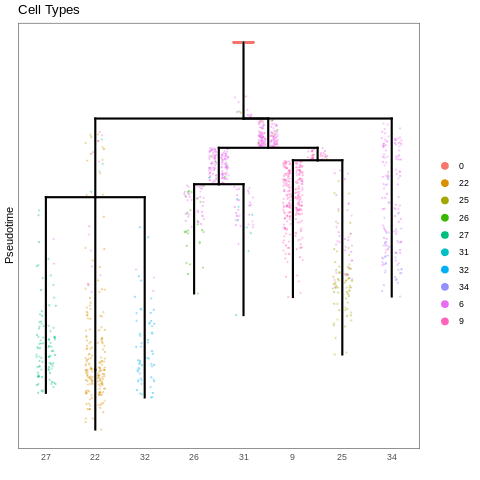

In [ ]:
# %%R
# #c("10","21","17","23","27","25","32","34","22")
# plotTree(lin.tree, "stage", title="Cell Types")

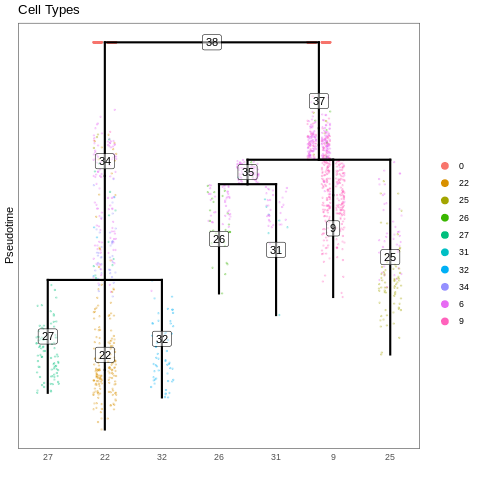

In [ ]:
%%R
#c("9","26","31","27","25","32","22")
plotTree(lin.tree, "stage", label.segments=T, title="Cell Types")

In [ ]:
#'XLOC_001934', 'XLOC_006720', 'XLOC_031548', HMG-box
# Myb-like 'XLOC_002947'
%%R
#c("9","26","31","27","25","32","22")
plotTree(lin.tree, 'XLOC_002947', title='XLOC_002947 Myb')


R[write to console]: Error in data.for.plot(object, label = label, label.type = label.type,  : 
  Cannot find XLOC_002947 in metadata, group.ids, signatures, genes, NMF modules, PCA, or pseudotime.

R[write to console]: In addition: 
R[write to console]: Warning messages:

R[write to console]: 1: 
R[write to console]: In assignCellsToSegments(object, pseudotime, verbose) :
R[write to console]: 
 
R[write to console]:  422 cells were not visited by a branch that exists at their pseudotime and were not assigned.

R[write to console]: 2: 
R[write to console]: In assignCellsToSegments(object, pseudotime, verbose) :
R[write to console]: 
 
R[write to console]:  422 cells were not visited by a branch that exists at their pseudotime and were not assigned.




Error in data.for.plot(object, label = label, label.type = label.type,  : 
  Cannot find XLOC_002947 in metadata, group.ids, signatures, genes, NMF modules, PCA, or pseudotime.


RInterpreterError: ignored

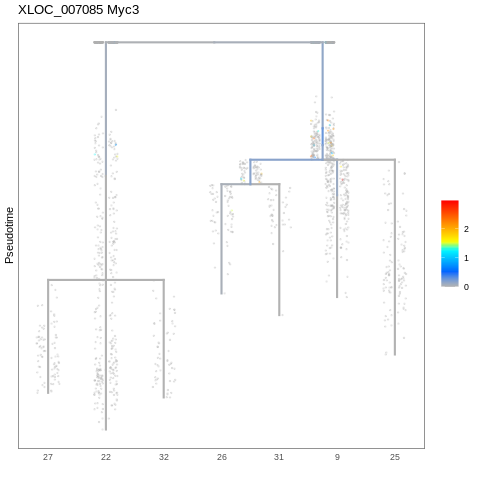

In [ ]:
#'XLOC_001934', 'XLOC_006720', 'XLOC_031548', HMG-box
# Myb-like 'XLOC_002947'
%%R
#c("9","26","31","27","25","32","22")
plotTree(lin.tree, 'XLOC_007085', title='XLOC_007085 Myc3')


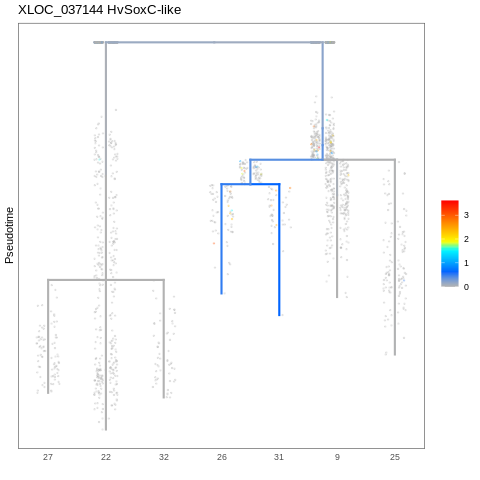

In [ ]:
#'XLOC_001934', 'XLOC_006720', 'XLOC_031548', HMG-box
# Myb-like 'XLOC_002947'
%%R
#c("9","26","31","27","25","32","22")
plotTree(lin.tree, 'XLOC_037144', title='XLOC_037144 HvSoxC-like')

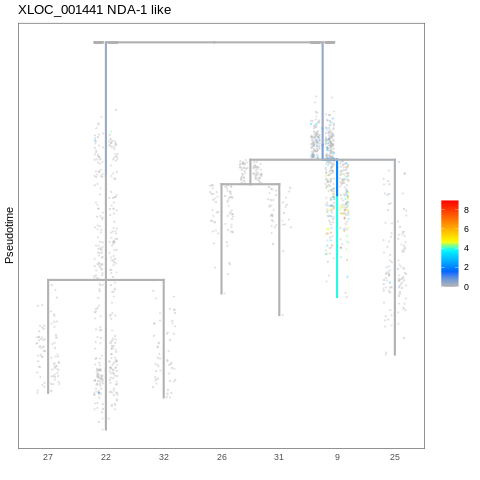

In [ ]:
#'XLOC_001934', 'XLOC_006720', 'XLOC_031548', HMG-box
# Myb-like 'XLOC_002947'
%%R
#c("9","26","31","27","25","32","22")
plotTree(lin.tree, 'XLOC_001441', title='XLOC_001441 NDA-1 like')

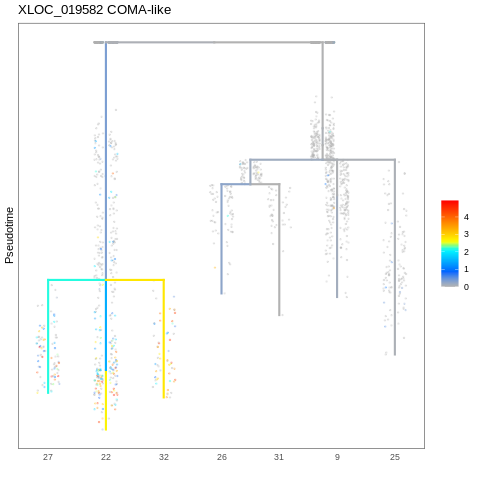

In [ ]:
#'XLOC_001934', 'XLOC_006720', 'XLOC_031548', HMG-box
# Myb-like 'XLOC_002947'
%%R
#c("9","26","31","27","25","32","22")
plotTree(lin.tree, 'XLOC_019582', title='XLOC_019582 COMA-like')

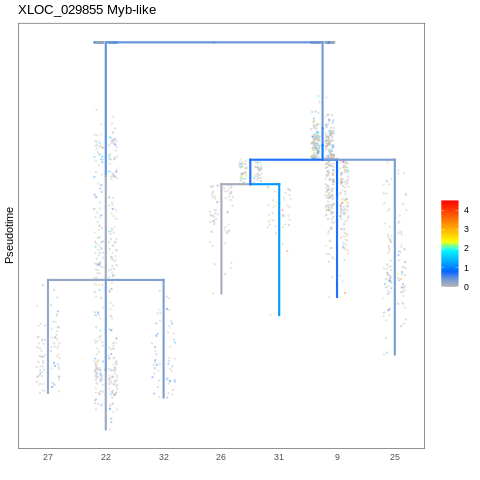

In [ ]:
#'XLOC_001934', 'XLOC_006720', 'XLOC_031548', HMG-box
# Myb-like 'XLOC_018971', 'XLOC_029855'
%%R
#c("9","26","31","27","25","32","22")
plotTree(lin.tree, 'XLOC_029855', title='XLOC_029855 Myb-like')


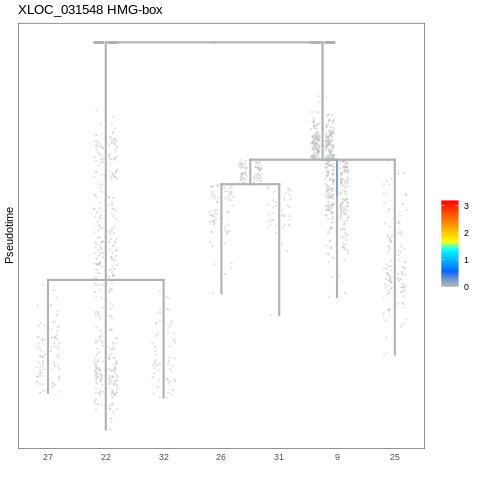

In [ ]:
#'XLOC_001934', 'XLOC_006720', 'XLOC_031548', HMG-box
# Myb-like 'XLOC_018971', 'XLOC_029855'
%%R
#c("9","26","31","27","25","32","22")
plotTree(lin.tree, 'XLOC_031548', title='XLOC_031548 HMG-box')


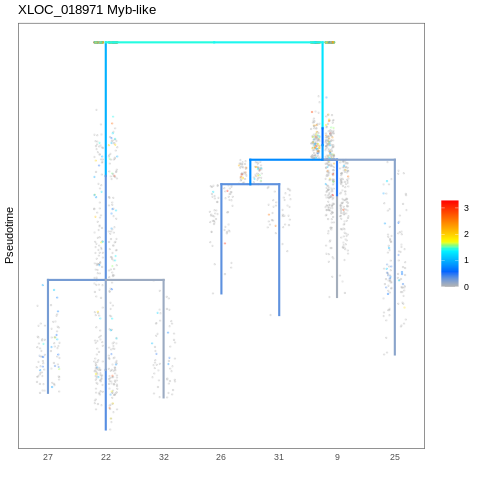

In [ ]:
#'XLOC_001934', 'XLOC_006720', 'XLOC_031548', HMG-box
# Myb-like 'XLOC_018971', 'XLOC_029855'
%%R
#c("9","26","31","27","25","32","22")
plotTree(lin.tree, 'XLOC_018971', title='XLOC_018971 Myb-like')


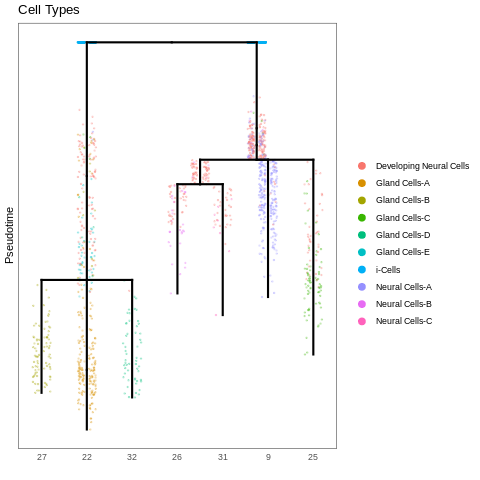

In [ ]:
%%R
#c("9","26","31","27","25","32","22")
plotTree(lin.tree, "name", title="Cell Types")

In [ ]:
%%R
tips.to.run <- c("9", "37","25")

Get DE genes along branches

In [ ]:
%%R
# Calculate the markers of each other population.
gene.markers <- list()
for (tipn in 1:length(tips.to.run)) {
  tip <- tips.to.run[tipn]
  print(paste0(Sys.time(), ": ", tip))
  markers <- aucprTestAlongTree(lin.tree, pseudotime="pseudotime", tips=tip, log.effect.size=0.4, auc.factor = 1.25, max.auc.threshold = 0.85, frac.must.express = 0.1, frac.min.diff = 0, root="38", only.return.global=F, must.beat.sibs=0.6, report.debug=T)
  gene.markers[[tip]] <- markers
}

[1] "2021-05-19 21:41:37: 9"
[1] "2021-05-19 21:43:22: 37"
[1] "2021-05-19 21:43:50: 25"


In [ ]:
%%R
gene.markers.de <- lapply(gene.markers, function(x) x[[1]])
gene.markers.stats <- lapply(gene.markers[1:23], function(x) x[[2]])
names(gene.markers.de) <- names(gene.markers)
names(gene.markers.stats) <- names(gene.markers)[1:23]


In [ ]:
%%R
toPlot <- c("9", "37","25")
gene <- list()
segment <- list()
p <- 1
for (c in toPlot){
  fname <- paste("20210519_seg", c,"DE_Gland_tips.pdf", sep = "")
  pdf(file=fname, width=7.5, height=10)
  for (i in rownames(gene.markers.de[[c]])){
    plot(plotTree(lin.tree,i, label.segments=T, title=i))

    gene[[p]] <- as.vector(i)
    segment[[p]] <- as.vector(c)

    p <- p+1

  }
  dev.off()
}




In [ ]:
%%R
deGenesSeg <- data.frame(Genes = unlist(gene), Segment = unlist(segment))
write.csv(deGenesSeg,"deGenesSeg.csv", row.names = FALSE)


##### **Test control tree with outgroup i-cell derived cells**

In [ ]:
%%R
neurDF <- t(as.matrix(readMM("controlLineage.mtx")))

genes <- read.table("controlGenes.csv", header = TRUE, sep = ",")
neurMeta <- read.table("controlLinMeta.csv", header = TRUE, sep = ",")

rownames(neurDF) <- genes$genes
colnames(neurDF) <- neurMeta$index

rownames(neurMeta) <- neurMeta$index


# Create an URD object, which will filter the data, then normalize and log-transform it.
lin <- createURD(count.data = neurDF, meta = neurMeta, min.cells=1, min.counts=1, max.genes.in.ram = 100)
lin

R[write to console]: 2021-04-23 21:38:10: Filtering cells by number of genes.

R[write to console]: 2021-04-23 21:38:29: Filtering genes by number of cells.

R[write to console]: 2021-04-23 21:38:50: Filtering genes by number of counts across entire data.

R[write to console]: 2021-04-23 21:39:07: Filtering genes by maximum observed expression.

R[write to console]: 2021-04-23 21:39:26: Creating URD object.

R[write to console]: 2021-04-23 21:39:28: Determining normalization factors.

R[write to console]: 2021-04-23 21:39:33: Normalizing and log-transforming the data.

R[write to console]: 2021-04-23 21:40:25: Finishing setup of the URD object.

R[write to console]: 2021-04-23 21:40:28: All done.



URD object: 21330 genes x 5147 cells.


In [ ]:
%%R
# Copy stage from @meta to @group.ids 
lin@group.ids$stage <- as.character(lin@meta[rownames(lin@group.ids),"cluster"])

# Get variable genes for each group of stages
# diffCV.cutoff can be varied to include more or fewer genes.
stages <- sort(unique(lin@group.ids$stage))
var.by.stage <- lapply(seq(length(stages)), function(n) {
  findVariableGenes(lin, cells.fit=cellsInCluster(lin, "stage", stages[n]), set.object.var.genes=F, diffCV.cutoff=0.3, mean.min=.005, mean.max=100, main.use=paste0("Stages ", stages[n]), do.plot=F)
})

In [ ]:
%%R
# Combine the results from each group of stages into a single list of variable genes and load into the URD object
var.genes <- sort(unique(unlist(var.by.stage)))
lin@var.genes <- var.genes

[1] "2021-04-23 21:41:38: Centering and scaling data."
[1] "2021-04-23 21:41:49: Removing genes with no variation."
[1] "2021-04-23 21:41:51: Calculating PCA."
[1] "2021-04-23 21:44:52: Estimating significant PCs."
[1] "Marchenko-Pastur eigenvalue null upper bound: 4.65879528419891"
[1] "31 PCs have eigenvalues larger than 2 times null upper bound."
[1] "Storing 62 PCs."


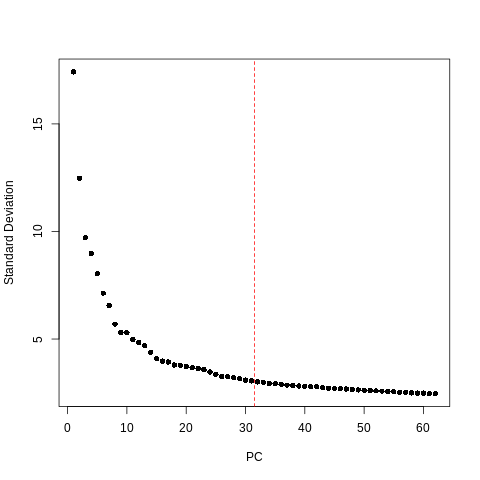

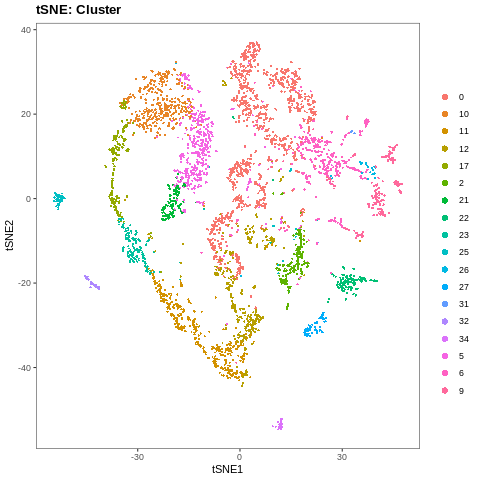

In [ ]:
%%R
# Calculate PCA and consider those PCs that with standard deviation 2x expected by noise as significant
lin <- calcPCA(lin, mp.factor = 2)
pcSDPlot(lin)

# Calculate tSNE
set.seed(42)
lin <- calcTsne(object = lin)
plotDim(lin, "stage", plot.title = "tSNE: Cluster")

[1] "destiny determined an optimal global sigma of 27.115"


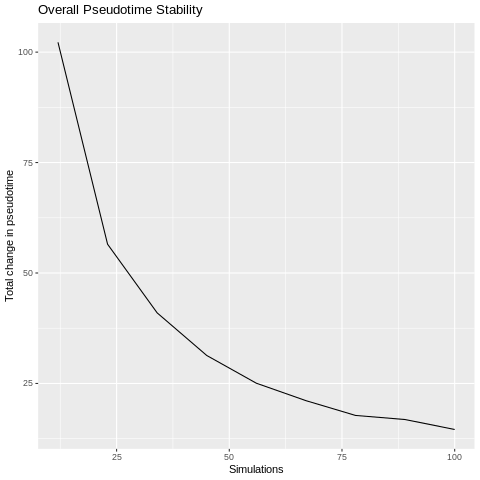

In [ ]:
%%R
# In this case, knn=100 (larger than sqrt(n.cells)) works well because there are not many cell types.
# Sigma 16 is slightly smaller than the sigma auto-determined by using NULL parameter.
lin <- calcDM(lin, knn = 60)
# Here we use all cells from the first stage as the root
root.cells <- cellsInCluster(lin, "stage", "0")

# Then we run 'flood' simulations
lin.floods <- floodPseudotime(lin, root.cells = root.cells, n=100, minimum.cells.flooded = 2, verbose=F)

# The we process the simulations into a pseudotime
lin <- floodPseudotimeProcess(lin, lin.floods, floods.name="pseudotime")

pseudotimePlotStabilityOverall(lin)



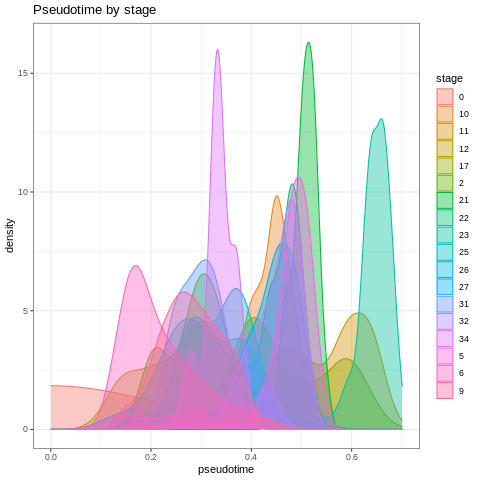

In [ ]:
%%R
#Check pseudotime assignments per cell type
plotDists(lin, "pseudotime", "stage", plot.title="Pseudotime by stage")

[1] "2021-04-23 22:14:02: Centering and scaling data."
[1] "2021-04-23 22:14:05: Removing genes with no variation."
[1] "2021-04-23 22:14:06: Calculating PCA."
[1] "2021-04-23 22:14:29: Estimating significant PCs."
[1] "Marchenko-Pastur eigenvalue null upper bound: 8.04989603099451"
[1] "28 PCs have eigenvalues larger than 1.5 times null upper bound."
[1] "Storing 56 PCs."


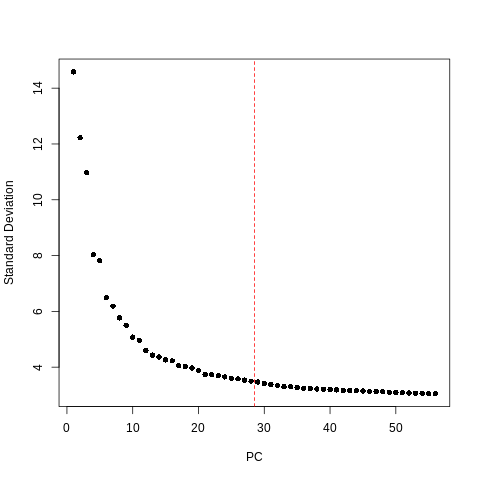

In [ ]:
%%R
# Create a subsetted object of just those cells from the final stage
#Test c(26,31,9,27,25,32,34,22,21, 23) , c(26,31,9,27,25,32,34,22, 23), c(26,31,9,27,25,32,34,22,10, 23)
lin.tips <- urdSubset(lin, cells.keep=cellsInCluster(lin, "stage",  c(26,31,9,27,25,32,34,22, 17,10,21, 23,2)))

# Use the variable genes that were calculated only on the final group of stages (which
# contain the last stage).
#lin.tips@var.genes <- var.by.stage[[4]]

# Calculate PCA and tSNE
lin.tips <- calcPCA(lin.tips, mp.factor = 1.5)
pcSDPlot(lin.tips)

[1] "Mean pseudotime back (~100 cells) 0.0132731806662228"
[1] "Chance of accepted move to equal pseudotime is 0.99009900990099"
[1] "Mean pseudotime forward (~0 cells) 0"


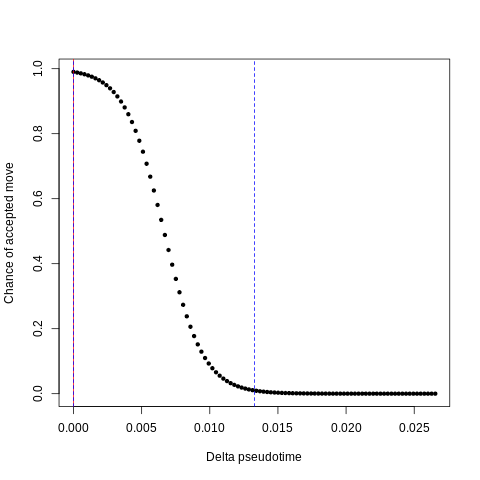

In [ ]:
%%R
# Calculate graph clustering of these cells
#lin.tips <- graphClustering(lin.tips, num.nn = 50, do.jaccard=T, method="Louvain")

# Copy cluster identities from axial.6somite object to a new clustering ("tip.clusters") in the full axial object.
lin@group.ids[rownames(lin.tips@group.ids), "tip.clusters"] <- lin.tips@group.ids$stage

# Determine the parameters of the logistic used to bias the transition probabilities. The procedure
# is relatively robust to this parameter, but the cell numbers may need to be modified for larger
# or smaller data sets.
lin.ptlogistic <- pseudotimeDetermineLogistic(lin, "pseudotime", optimal.cells.forward=0, max.cells.back=100, do.plot = T) #20, 40

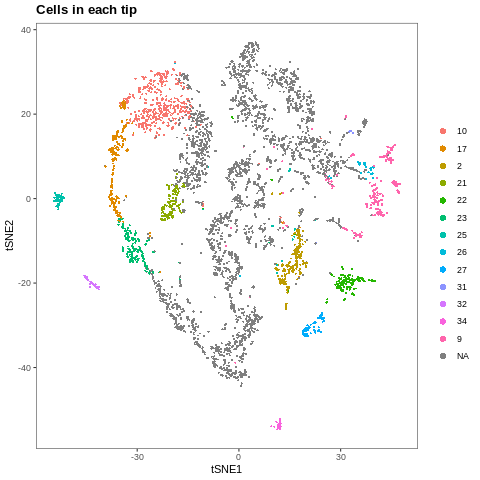

In [ ]:
%%R
# Bias the transition matrix acording to pseudotime
lin.biased.tm <- as.matrix(pseudotimeWeightTransitionMatrix(lin, "pseudotime", logistic.params=lin.ptlogistic))

# Simulate the biased random walks from each tip
lin.walks <- simulateRandomWalksFromTips(lin, tip.group.id="tip.clusters", root.cells=root.cells, transition.matrix = lin.biased.tm,n.per.tip = 20000, root.visits = 1, max.steps = 5000, verbose = F)

# Process the biased random walks into visitation frequencies
lin <- processRandomWalksFromTips(lin, lin.walks, verbose = F)

#Plot tips
plotDim(lin, "tip.clusters", plot.title="Cells in each tip")


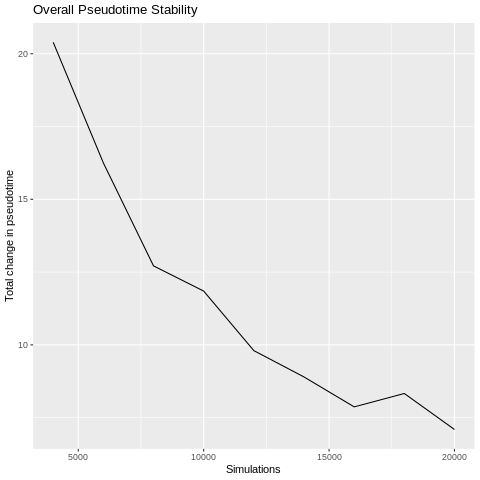

In [ ]:
%%R
pseudotimePlotStabilityOverall(lin)

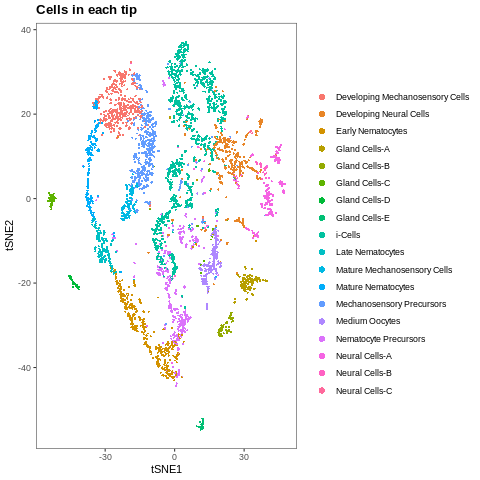

In [ ]:
%%R
plotDim(lin, "name", plot.title="Cells in each tip")

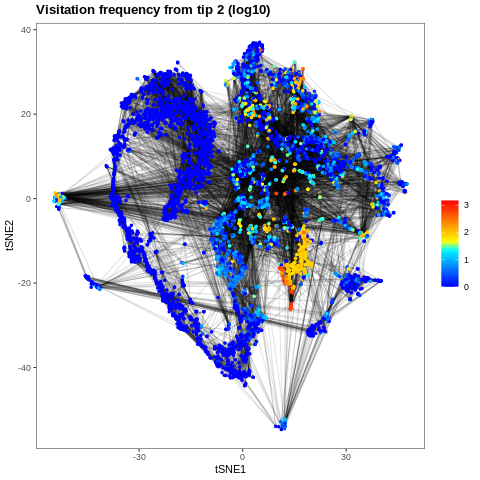

In [ ]:
%%R
#Plot visitation frequencies from tips
plotDim(lin, "visitfreq.log.2", plot.title="Visitation frequency from tip 2 (log10)", transitions.plot=10000)



In [ ]:
%%R
# Load the cells used for each tip into the URD object
lin.tree <- loadTipCells(lin, "tip.clusters")

# # Combine the two small clusters in a single population into one tip
# lin.tree <- combineTipVisitation(lin.tree, "16", "5", new.tip = "16")

# Build the tree,  c(10,21,17,23,27,25,32,34,22) = tips
#c("26","31","9","27","25","32","22", "23")
#c("26","31","9","27","25","32","22", "23","21")

#c("26","31","9","27","25","32","22", "17","21")
#c("26","31","9","27","25","32","22", "17")
lin.tree <- buildTree(lin.tree, pseudotime = "pseudotime", tips.use=c("26","31","9","27","25","32","22", "23","21","10", "2")  , divergence.method = "preference", cells.per.pseudotime.bin = 30, bins.per.pseudotime.window = 8, save.all.breakpoint.info = T, p.thresh=0.005)

[1] "Calculating divergence between 26 and 31 (Pseudotime 0 to 0.414)"
[1] "Calculating divergence between 26 and 9 (Pseudotime 0 to 0.414)"
[1] "Calculating divergence between 26 and 27 (Pseudotime 0 to 0.414)"
[1] "Calculating divergence between 26 and 25 (Pseudotime 0 to 0.414)"
[1] "Calculating divergence between 26 and 32 (Pseudotime 0 to 0.414)"
[1] "Calculating divergence between 26 and 22 (Pseudotime 0 to 0.414)"
[1] "Calculating divergence between 26 and 23 (Pseudotime 0 to 0.414)"


R[write to console]: Difference between 26 and 23 always TRUE -- setting breakpoint to beginning.



[1] "Calculating divergence between 26 and 21 (Pseudotime 0 to 0.414)"
[1] "Calculating divergence between 26 and 10 (Pseudotime 0 to 0.414)"
[1] "Calculating divergence between 26 and 2 (Pseudotime 0 to 0.414)"


R[write to console]: Difference between 26 and 2 always TRUE -- setting breakpoint to beginning.



[1] "Calculating divergence between 31 and 9 (Pseudotime 0 to 0.432)"
[1] "Calculating divergence between 31 and 27 (Pseudotime 0 to 0.432)"
[1] "Calculating divergence between 31 and 25 (Pseudotime 0 to 0.429)"
[1] "Calculating divergence between 31 and 32 (Pseudotime 0 to 0.432)"
[1] "Calculating divergence between 31 and 22 (Pseudotime 0 to 0.432)"
[1] "Calculating divergence between 31 and 23 (Pseudotime 0 to 0.432)"


R[write to console]: Difference between 31 and 23 always TRUE -- setting breakpoint to beginning.



[1] "Calculating divergence between 31 and 21 (Pseudotime 0 to 0.432)"
[1] "Calculating divergence between 31 and 10 (Pseudotime 0 to 0.432)"
[1] "Calculating divergence between 31 and 2 (Pseudotime 0 to 0.432)"


R[write to console]: Difference between 31 and 2 always TRUE -- setting breakpoint to beginning.



[1] "Calculating divergence between 9 and 27 (Pseudotime 0 to 0.452)"
[1] "Calculating divergence between 9 and 25 (Pseudotime 0 to 0.429)"
[1] "Calculating divergence between 9 and 32 (Pseudotime 0 to 0.452)"
[1] "Calculating divergence between 9 and 22 (Pseudotime 0 to 0.452)"
[1] "Calculating divergence between 9 and 23 (Pseudotime 0 to 0.452)"


R[write to console]: Difference between 9 and 23 always TRUE -- setting breakpoint to beginning.



[1] "Calculating divergence between 9 and 21 (Pseudotime 0 to 0.452)"
[1] "Calculating divergence between 9 and 10 (Pseudotime 0 to 0.452)"
[1] "Calculating divergence between 9 and 2 (Pseudotime 0 to 0.445)"


R[write to console]: Difference between 9 and 2 always TRUE -- setting breakpoint to beginning.



[1] "Calculating divergence between 27 and 25 (Pseudotime 0 to 0.429)"
[1] "Calculating divergence between 27 and 32 (Pseudotime 0 to 0.506)"
[1] "Calculating divergence between 27 and 22 (Pseudotime 0 to 0.509)"
[1] "Calculating divergence between 27 and 23 (Pseudotime 0 to 0.509)"


R[write to console]: Difference between 27 and 23 always TRUE -- setting breakpoint to beginning.



[1] "Calculating divergence between 27 and 21 (Pseudotime 0 to 0.509)"
[1] "Calculating divergence between 27 and 10 (Pseudotime 0 to 0.509)"


R[write to console]: Difference between 27 and 10 always TRUE -- setting breakpoint to beginning.



[1] "Calculating divergence between 27 and 2 (Pseudotime 0 to 0.445)"


R[write to console]: Difference between 27 and 2 always TRUE -- setting breakpoint to beginning.



[1] "Calculating divergence between 25 and 32 (Pseudotime 0 to 0.429)"
[1] "Calculating divergence between 25 and 22 (Pseudotime 0 to 0.429)"
[1] "Calculating divergence between 25 and 23 (Pseudotime 0 to 0.429)"


R[write to console]: Difference between 25 and 23 always TRUE -- setting breakpoint to beginning.



[1] "Calculating divergence between 25 and 21 (Pseudotime 0 to 0.429)"
[1] "Calculating divergence between 25 and 10 (Pseudotime 0 to 0.429)"


R[write to console]: Difference between 25 and 10 always TRUE -- setting breakpoint to beginning.



[1] "Calculating divergence between 25 and 2 (Pseudotime 0 to 0.429)"


R[write to console]: Difference between 25 and 2 always TRUE -- setting breakpoint to beginning.



[1] "Calculating divergence between 32 and 22 (Pseudotime 0 to 0.506)"
[1] "Calculating divergence between 32 and 23 (Pseudotime 0 to 0.506)"


R[write to console]: Difference between 32 and 23 always TRUE -- setting breakpoint to beginning.



[1] "Calculating divergence between 32 and 21 (Pseudotime 0 to 0.506)"
[1] "Calculating divergence between 32 and 10 (Pseudotime 0 to 0.506)"


R[write to console]: Difference between 32 and 10 always TRUE -- setting breakpoint to beginning.



[1] "Calculating divergence between 32 and 2 (Pseudotime 0 to 0.445)"


R[write to console]: Difference between 32 and 2 always TRUE -- setting breakpoint to beginning.



[1] "Calculating divergence between 22 and 23 (Pseudotime 0 to 0.531)"
[1] "Calculating divergence between 22 and 21 (Pseudotime 0 to 0.531)"
[1] "Calculating divergence between 22 and 10 (Pseudotime 0 to 0.531)"


R[write to console]: Difference between 22 and 10 always TRUE -- setting breakpoint to beginning.



[1] "Calculating divergence between 22 and 2 (Pseudotime 0 to 0.445)"


R[write to console]: Difference between 22 and 2 always TRUE -- setting breakpoint to beginning.



[1] "Calculating divergence between 23 and 21 (Pseudotime 0 to 0.552)"
[1] "Calculating divergence between 23 and 10 (Pseudotime 0 to 0.535)"
[1] "Calculating divergence between 23 and 2 (Pseudotime 0 to 0.445)"


R[write to console]: Difference between 23 and 2 always TRUE -- setting breakpoint to beginning.



[1] "Calculating divergence between 21 and 10 (Pseudotime 0 to 0.535)"
[1] "Calculating divergence between 21 and 2 (Pseudotime 0 to 0.445)"


R[write to console]: Difference between 21 and 2 always TRUE -- setting breakpoint to beginning.



[1] "Calculating divergence between 10 and 2 (Pseudotime 0 to 0.445)"


R[write to console]: Difference between 10 and 2 always TRUE -- setting breakpoint to beginning.



[1] "Joining segments 27 and 32 at pseudotime 0.385 to create segment 33"
[1] "Calculating divergence between 26 and 33 (Pseudotime 0 to 0.385)"
[1] "Calculating divergence between 31 and 33 (Pseudotime 0 to 0.385)"
[1] "Calculating divergence between 9 and 33 (Pseudotime 0 to 0.385)"
[1] "Calculating divergence between 25 and 33 (Pseudotime 0 to 0.385)"
[1] "Calculating divergence between 22 and 33 (Pseudotime 0 to 0.385)"


R[write to console]: Difference between 22 and 33 always FALSE -- setting breakpoint to end.



[1] "Calculating divergence between 23 and 33 (Pseudotime 0 to 0.385)"


R[write to console]: Difference between 23 and 33 always TRUE -- setting breakpoint to beginning.



[1] "Calculating divergence between 21 and 33 (Pseudotime 0 to 0.385)"
[1] "Calculating divergence between 10 and 33 (Pseudotime 0 to 0.385)"


R[write to console]: Difference between 10 and 33 always TRUE -- setting breakpoint to beginning.



[1] "Calculating divergence between 2 and 33 (Pseudotime 0 to 0.385)"


R[write to console]: Difference between 2 and 33 always TRUE -- setting breakpoint to beginning.



[1] "Joining segments 22 and 33 at pseudotime 0.385 to create segment 34"
[1] "Calculating divergence between 26 and 34 (Pseudotime 0 to 0.385)"
[1] "Calculating divergence between 31 and 34 (Pseudotime 0 to 0.385)"
[1] "Calculating divergence between 9 and 34 (Pseudotime 0 to 0.385)"
[1] "Calculating divergence between 25 and 34 (Pseudotime 0 to 0.385)"
[1] "Calculating divergence between 23 and 34 (Pseudotime 0 to 0.385)"


R[write to console]: Difference between 23 and 34 always TRUE -- setting breakpoint to beginning.



[1] "Calculating divergence between 21 and 34 (Pseudotime 0 to 0.385)"
[1] "Calculating divergence between 10 and 34 (Pseudotime 0 to 0.385)"


R[write to console]: Difference between 10 and 34 always TRUE -- setting breakpoint to beginning.



[1] "Calculating divergence between 2 and 34 (Pseudotime 0 to 0.385)"


R[write to console]: Difference between 2 and 34 always TRUE -- setting breakpoint to beginning.



[1] "Joining segments 21 and 10 at pseudotime 0.284 to create segment 35"
[1] "Calculating divergence between 26 and 35 (Pseudotime 0 to 0.284)"
[1] "Calculating divergence between 31 and 35 (Pseudotime 0 to 0.284)"
[1] "Calculating divergence between 9 and 35 (Pseudotime 0 to 0.284)"
[1] "Calculating divergence between 25 and 35 (Pseudotime 0 to 0.284)"


R[write to console]: Difference between 25 and 35 always TRUE -- setting breakpoint to beginning.



[1] "Calculating divergence between 23 and 35 (Pseudotime 0 to 0.284)"
[1] "Calculating divergence between 2 and 35 (Pseudotime 0 to 0.284)"


R[write to console]: Difference between 2 and 35 always TRUE -- setting breakpoint to beginning.



[1] "Calculating divergence between 34 and 35 (Pseudotime 0 to 0.284)"


R[write to console]: Difference between 34 and 35 always TRUE -- setting breakpoint to beginning.



[1] "Joining segments 9 and 25 at pseudotime 0.16 to create segment 36"
[1] "Calculating divergence between 26 and 36 (Pseudotime 0 to 0.16)"


R[write to console]: Difference between 26 and 36 always FALSE -- setting breakpoint to end.



[1] "Calculating divergence between 31 and 36 (Pseudotime 0 to 0.16)"


R[write to console]: Difference between 31 and 36 always FALSE -- setting breakpoint to end.



[1] "Calculating divergence between 23 and 36 (Pseudotime 0 to 0.16)"


R[write to console]: Difference between 23 and 36 always TRUE -- setting breakpoint to beginning.



[1] "Calculating divergence between 2 and 36 (Pseudotime 0 to 0.16)"


R[write to console]: Difference between 2 and 36 always TRUE -- setting breakpoint to beginning.



[1] "Calculating divergence between 34 and 36 (Pseudotime 0 to 0.16)"


R[write to console]: Difference between 34 and 36 always FALSE -- setting breakpoint to end.



[1] "Calculating divergence between 35 and 36 (Pseudotime 0 to 0.16)"
[1] "Joining segments 26 and 36 at pseudotime 0.16 to create segment 37"
[1] "Calculating divergence between 31 and 37 (Pseudotime 0 to 0.16)"


R[write to console]: Difference between 31 and 37 always FALSE -- setting breakpoint to end.



[1] "Calculating divergence between 23 and 37 (Pseudotime 0 to 0.16)"
[1] "Calculating divergence between 2 and 37 (Pseudotime 0 to 0.16)"


R[write to console]: Difference between 2 and 37 always TRUE -- setting breakpoint to beginning.



[1] "Calculating divergence between 34 and 37 (Pseudotime 0 to 0.16)"


R[write to console]: Difference between 34 and 37 always FALSE -- setting breakpoint to end.



[1] "Calculating divergence between 35 and 37 (Pseudotime 0 to 0.16)"


R[write to console]: Difference between 35 and 37 always FALSE -- setting breakpoint to end.



[1] "Joining segments 31 and 37 at pseudotime 0.16 to create segment 38"
[1] "Calculating divergence between 23 and 38 (Pseudotime 0 to 0.16)"
[1] "Calculating divergence between 2 and 38 (Pseudotime 0 to 0.16)"


R[write to console]: Difference between 2 and 38 always TRUE -- setting breakpoint to beginning.



[1] "Calculating divergence between 34 and 38 (Pseudotime 0 to 0.16)"


R[write to console]: Difference between 34 and 38 always FALSE -- setting breakpoint to end.



[1] "Calculating divergence between 35 and 38 (Pseudotime 0 to 0.16)"


R[write to console]: Difference between 35 and 38 always FALSE -- setting breakpoint to end.



[1] "Joining segments 34 and 38 at pseudotime 0.16 to create segment 39"
[1] "Calculating divergence between 23 and 39 (Pseudotime 0 to 0.16)"
[1] "Calculating divergence between 2 and 39 (Pseudotime 0 to 0.16)"


R[write to console]: Difference between 2 and 39 always TRUE -- setting breakpoint to beginning.



[1] "Calculating divergence between 35 and 39 (Pseudotime 0 to 0.16)"


R[write to console]: Difference between 35 and 39 always FALSE -- setting breakpoint to end.



[1] "Joining segments 35 and 39 at pseudotime 0.16 to create segment 40"
[1] "Calculating divergence between 23 and 40 (Pseudotime 0 to 0.16)"


R[write to console]: Difference between 23 and 40 always FALSE -- setting breakpoint to end.



[1] "Calculating divergence between 2 and 40 (Pseudotime 0 to 0.16)"
[1] "Joining segments 23 and 40 at pseudotime 0.16 to create segment 41"
[1] "Calculating divergence between 2 and 41 (Pseudotime 0 to 0.16)"
[1] "Joining segments 2 and 41 at pseudotime 0 to create segment 42"
[1] "Assigning cells to segments."
[1] "Collapsing short segments."
[1] "Removing singleton segments."
[1] "Reassigning cells to segments."
[1] "Assigning cells to nodes."
[1] "Laying out tree."
[1] "Adding cells to tree."


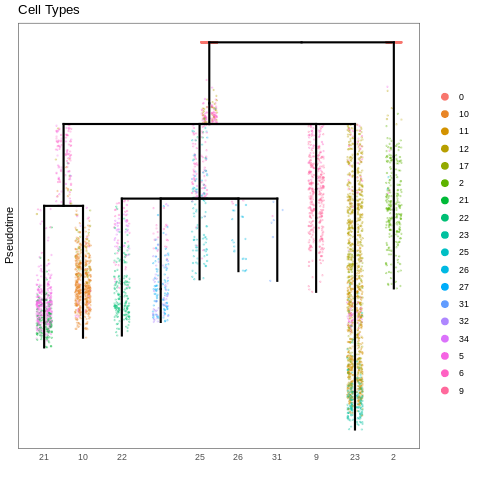

In [ ]:
%%R
#c("26","31","9","27","25","32","22", "23","21","10", "2"), pseudotime 50
plotTree(lin.tree, "stage", title="Cell Types")

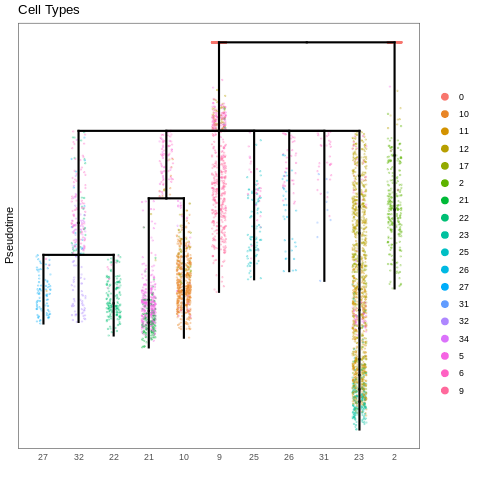

In [ ]:
%%R
#c("26","31","9","27","25","32","22", "23","21","10", "2"), pseudotime 30
plotTree(lin.tree, "stage", title="Cell Types")

### **Run trajectory analysis for all Nematocytes**

####**Generate Pseudotime Trajectories for I-cells, Neurons, Nematocytes**

Select cell types 0, 11, 12, 17, 23 6, 9, 26 & 31 which represent the i-cells, Neural cells, and Nematocytes for downstream analysis

In [14]:
#Subset data

#I-cells, neurons, nematocytes
big_lin = bus_fs_raw[bus_fs_raw.obs['cellRanger_louvain'].isin([31,26,6,9,0,11,12,17,23,5,10,21])]


sc.pp.filter_cells(big_lin, min_counts=0)
sc.pp.filter_genes(big_lin, min_counts=1)
sc.pp.normalize_per_cell(big_lin, counts_per_cell_after=1e4)

big_lin_copy = big_lin.copy()
sc.pp.log1p(big_lin)

big_lin.raw = sc.pp.log1p(big_lin_copy, copy=True)


sc.pp.highly_variable_genes(big_lin, n_top_genes=4000,n_bins=50)

big_lin = big_lin[:,big_lin.var['highly_variable']]

big_lin



Trying to set attribute `.obs` of view, copying.


View of AnnData object with n_obs × n_vars = 5481 × 4000
    obs: 'batch', 'cellRanger_louvain', 'fed', 'orgID', 'annos', 'annosSub', 'n_counts'
    var: 'n_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'annos_colors', 'cellRanger_louvain_colors', 'log1p', 'hvg'

Cluster and embed cells for pseudotime visualization

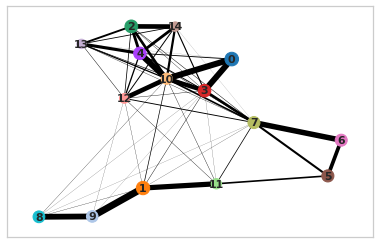

In [15]:
#Large lineage PAGA embedding

big_lin_scaled = big_lin
sc.pp.scale(big_lin_scaled, max_value=10)

sc.tl.pca(big_lin_scaled, n_comps=60)
#sc.pl.pca_variance_ratio(neur_lin_scaled, log=True)
sc.pp.neighbors(big_lin_scaled,n_neighbors=50, n_pcs=15,method='gauss')

sc.tl.louvain(big_lin_scaled,resolution=1,key_added='louvain_test')#Clustering algorithm,resolution=0.5


sc.tl.paga(big_lin_scaled, groups='louvain_test',)
sc.pl.paga(big_lin_scaled, color=['louvain_test'])

In [16]:
#Add neuron subpopulation labels
labels = []
for c in big_lin_scaled.obs_names:
  if c in neuron_subpops.obs_names:

    labels += [neuron_subpops[c,:].obs['louvain_neur'][0]]
  else:
    labels += ['rest']

big_lin_scaled.obs['louvain_neur'] = pd.Categorical(labels)

In [17]:
sc.tl.draw_graph(big_lin_scaled, init_pos='paga')
#sc.pl.draw_graph(big_lin_scaled, color=['louvain_test','louvain_neur','cellRanger_louvain','fed'], legend_loc='on data',color_map='viridis',alpha=0.5)

In [18]:
#Calculate pseudotime with diffusion components (dim reduction)

big_lin_scaled.uns['iroot'] = np.flatnonzero(big_lin_scaled.obs['louvain_test']  == '0')[0]
sc.tl.diffmap(big_lin_scaled,n_comps=10)
sc.tl.dpt(big_lin_scaled,n_dcs=10)


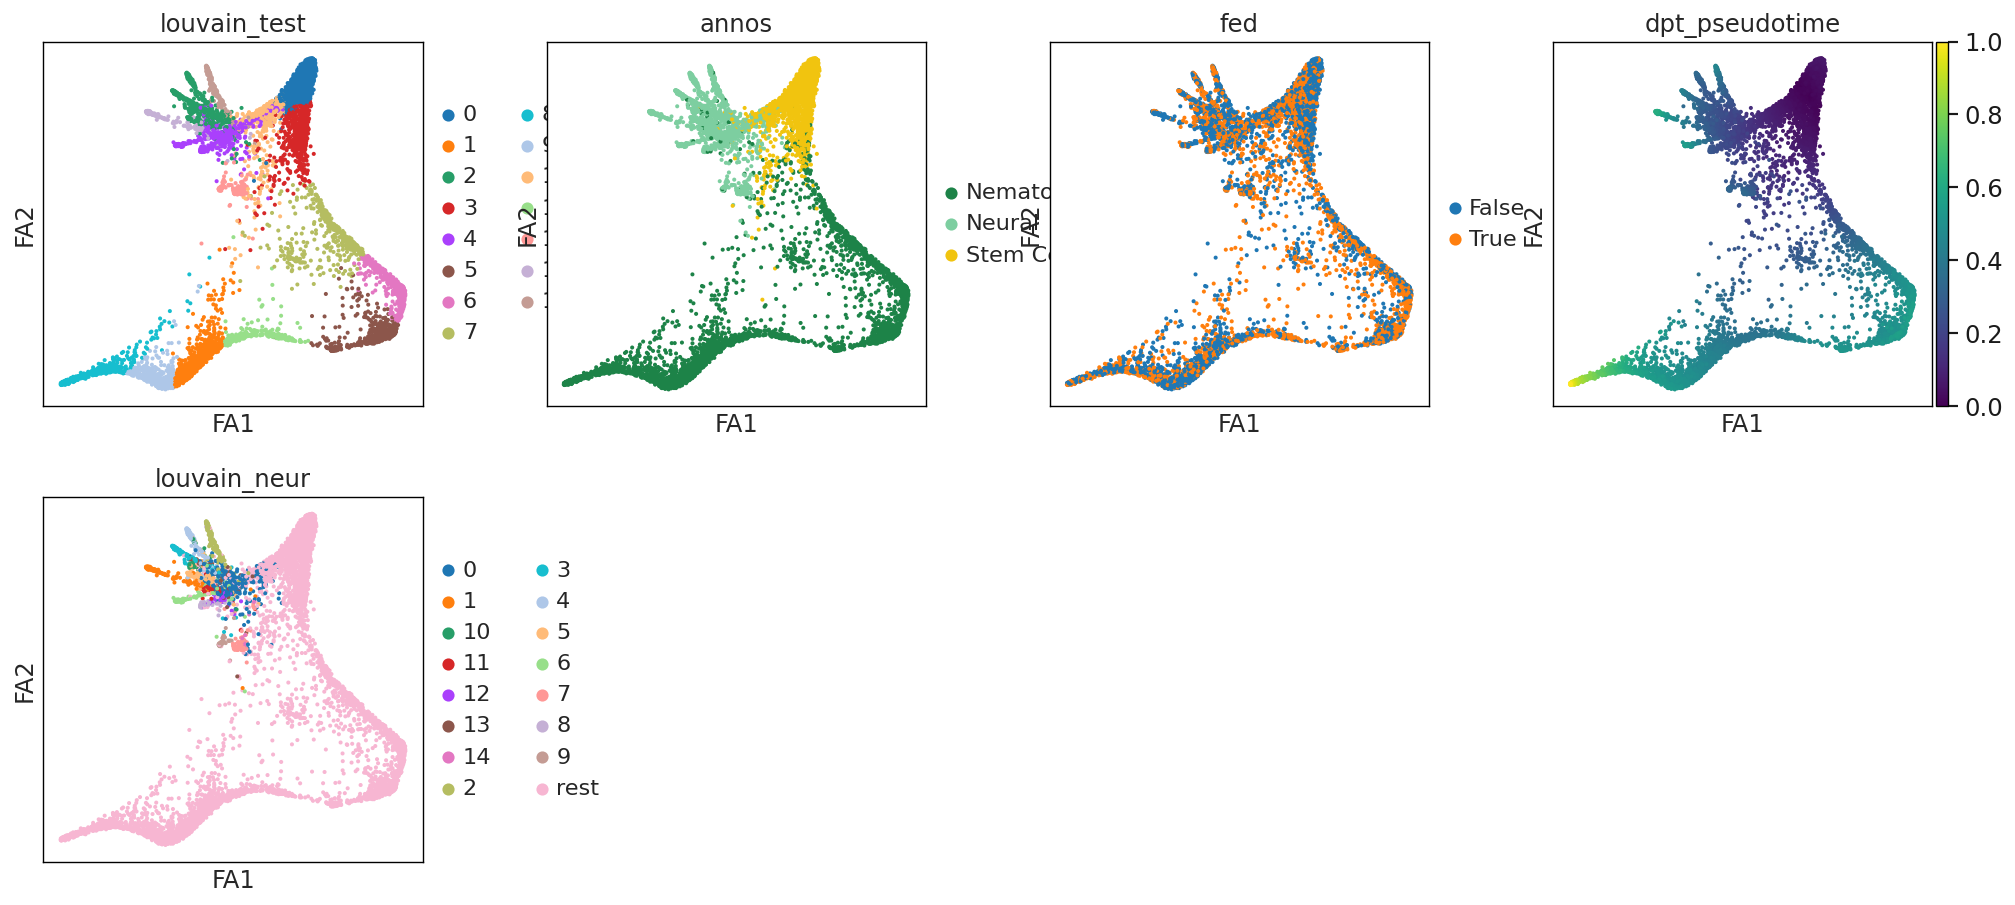

In [19]:
sc.set_figure_params(dpi=125)
sc.pl.draw_graph(big_lin_scaled, color=['louvain_test','annos','fed','dpt_pseudotime','louvain_neur'], color_map='viridis') #legend_loc='on data'

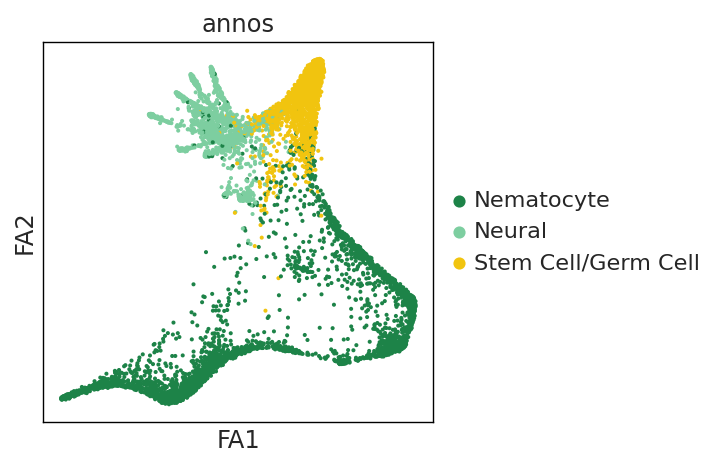

In [20]:
sc.pl.draw_graph(big_lin_scaled, color=['annos'], color_map='viridis') #legend_loc='on data'


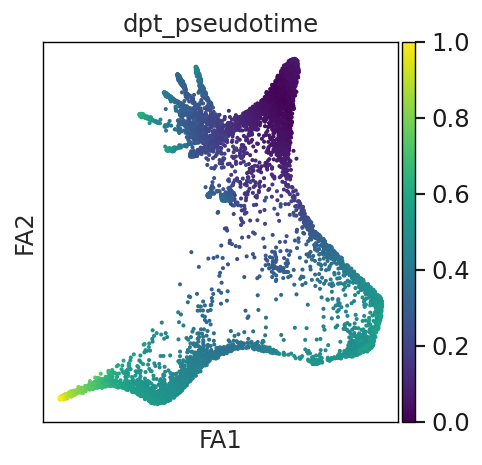

In [21]:
sc.pl.draw_graph(big_lin_scaled, color=['dpt_pseudotime'], color_map='viridis') #legend_loc='on data'

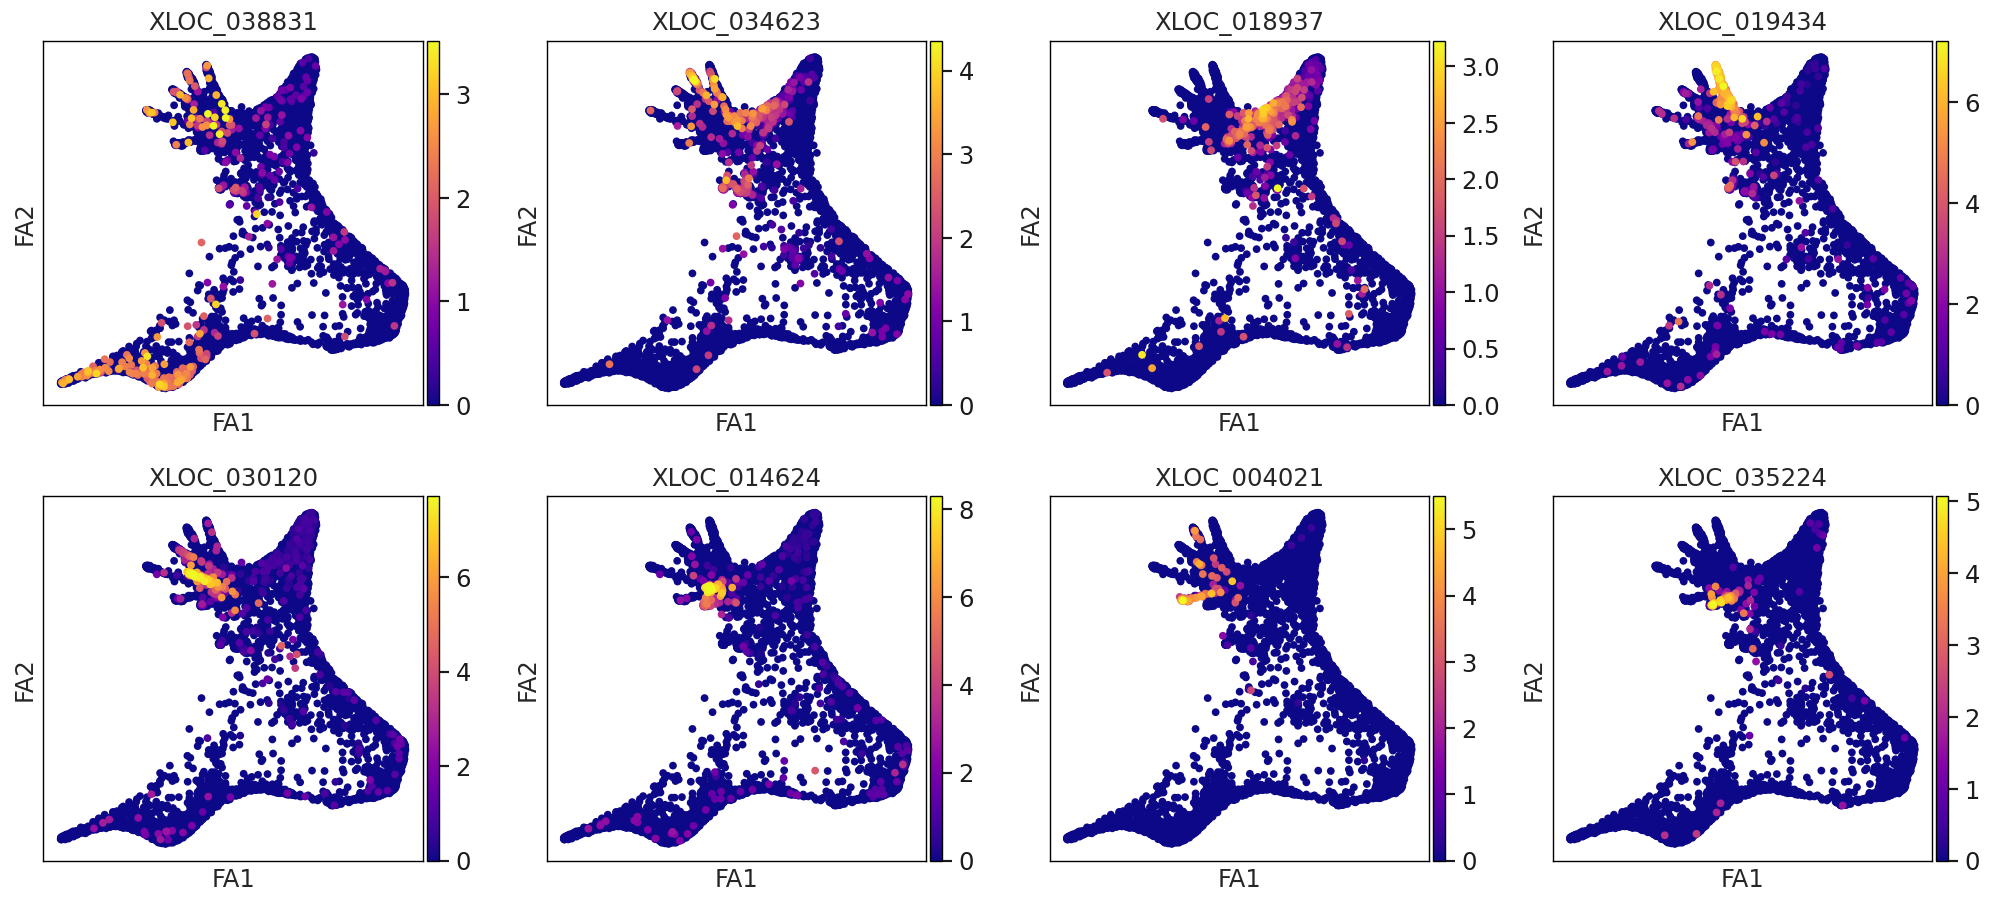

In [22]:
# 'XLOC_004102' nematocilin, XLOC_017744  as Asc-a-1
sc.pl.draw_graph(big_lin_scaled, color=['XLOC_038831','XLOC_034623','XLOC_018937','XLOC_019434','XLOC_030120',
                                        'XLOC_014624','XLOC_004021','XLOC_035224'], 
                 legend_loc='on data',color_map='plasma',s=80) 



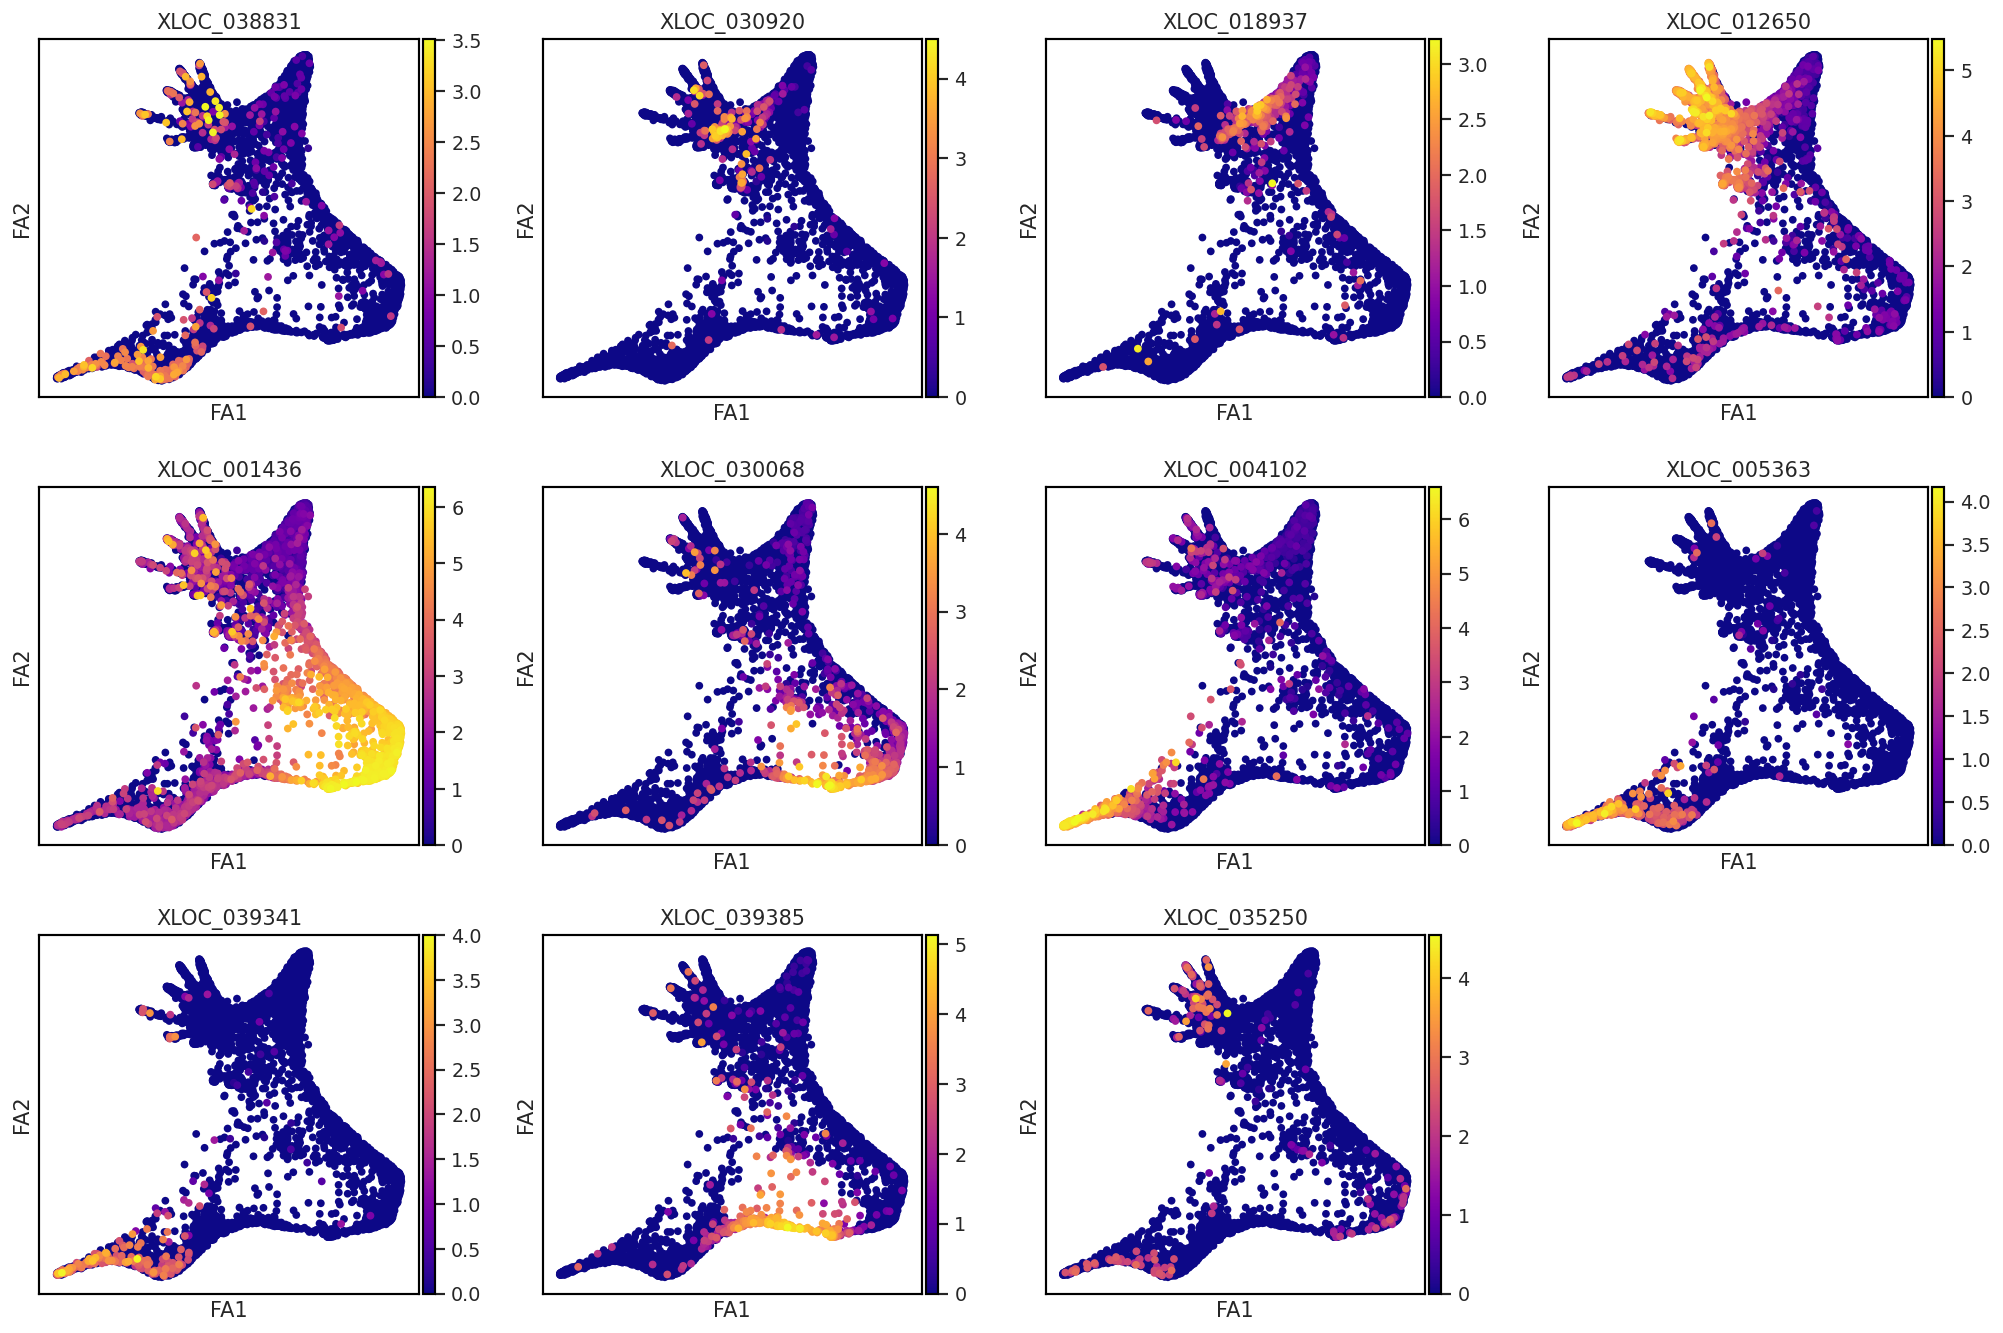

In [ ]:
# 'XLOC_004102' nematocilin, XLOC_017744  as Asc-a-1
sc.pl.draw_graph(big_lin_scaled, color=['XLOC_038831','XLOC_030920','XLOC_018937','XLOC_012650','XLOC_001436','XLOC_030068',
                                        'XLOC_004102','XLOC_005363','XLOC_039341',
                                        'XLOC_039385','XLOC_035250'], 
                 legend_loc='on data',color_map='plasma',s=80) 



Make adata object including more variable genes to rank by their importance/relevance to the pseudotime trajectories

In [ ]:
#Make adata for doing regression (more variable genes included)
big_lin_reg = bus_fs_raw[bus_fs_raw.obs['cellRanger_louvain'].isin([31,26,6,9,0,11,12,17,23,5,10,21])]


sc.pp.filter_cells(big_lin_reg, min_counts=0)
sc.pp.filter_genes(big_lin_reg, min_counts=1)
sc.pp.normalize_per_cell(big_lin_reg, counts_per_cell_after=1e4)

big_lin_copy = big_lin_reg.copy()
sc.pp.log1p(big_lin_reg)

big_lin_reg.raw = sc.pp.log1p(big_lin_copy, copy=True)

#For shorter demonstration use 4000 option
#sc.pp.highly_variable_genes(big_lin_reg, n_top_genes=4000,n_bins=10)
sc.pp.highly_variable_genes(big_lin_reg, n_top_genes=15000,n_bins=10) 

big_lin_reg = big_lin_reg[:,big_lin_reg.var['highly_variable']]


Trying to set attribute `.obs` of view, copying.


In [ ]:
#Convert pseudotime valeus to quantiles of pseudotime 
big_lin_reg.obs['dpt_pseudotime'] = big_lin_scaled.obs['dpt_pseudotime']

nbins = 20 #quantiles
rangeList = range(0,nbins)
strList = [str(i) for i in rangeList]

cnido = big_lin_reg[big_lin_reg.obs['cellRanger_louvain'].isin([0,11,12,17,23,5,10,21])]
cnido.obs['quantTimeBlocks'] = pd.qcut(cnido.obs['dpt_pseudotime'],q=nbins,labels=strList)

neuro = big_lin_reg[big_lin_reg.obs['cellRanger_louvain'].isin([0,26,31,9,6])]
neuro.obs['quantTimeBlocks'] = pd.qcut(neuro.obs['dpt_pseudotime'],q=nbins,labels=strList)

Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.


In [ ]:
cnido.write('nemato.h5ad')
neuro.write('neuro.h5ad')

In [ ]:
big_lin_scaled

AnnData object with n_obs × n_vars = 5481 × 3999
    obs: 'batch', 'cellRanger_louvain', 'fed', 'orgID', 'annos', 'annosSub', 'n_counts', 'louvain_test', 'louvain_neur', 'dpt_pseudotime'
    var: 'n_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'annos_colors', 'cellRanger_louvain_colors', 'log1p', 'hvg', 'pca', 'neighbors', 'louvain', 'paga', 'louvain_test_sizes', 'louvain_test_colors', 'draw_graph', 'iroot', 'diffmap_evals', 'fed_colors', 'louvain_neur_colors'
    obsm: 'X_pca', 'X_draw_graph_fa', 'X_diffmap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [ ]:
#Create embedding for plotting pseudotime genes
big_lin_reg.uns['paga'] = big_lin_scaled.uns['paga'] 

big_lin_reg.uns['draw_graph'] = big_lin_scaled.uns['draw_graph']

big_lin_reg.obsm['X_draw_graph_fa'] = big_lin_scaled.obsm['X_draw_graph_fa']


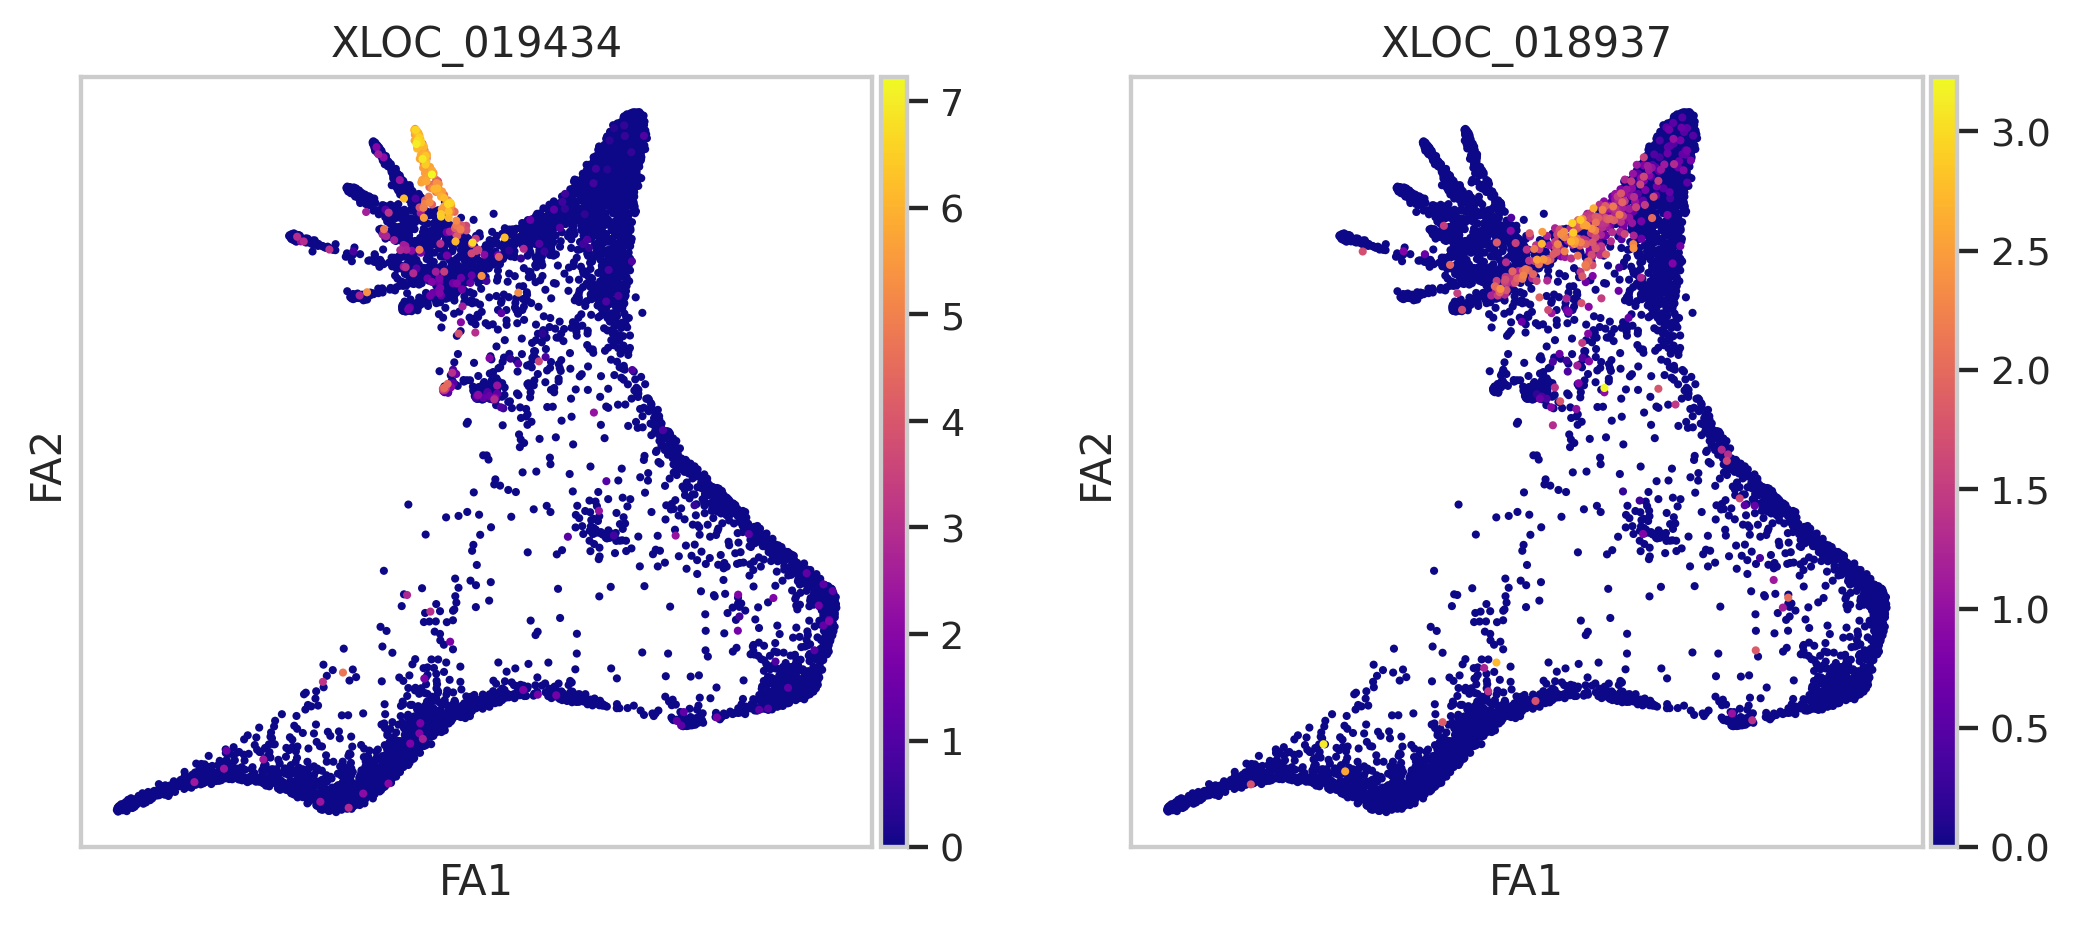

In [ ]:
sc.pl.draw_graph(big_lin_reg, color=['XLOC_019434','XLOC_018937'], 
                 legend_loc='on data',color_map='plasma') 

In [ ]:
big_lin_reg.write('pseudoEmbed_fullLineage.h5ad')

##### **Run Regression**
Will take a while. Can plot with saved results instead of re-running model or run with fewer genes

In [ ]:
#Run regression

result_cnido = runRegr_dptPseudotime(cnido,cnido,'quantTimeBlocks')
result_neuro = runRegr_dptPseudotime(neuro,neuro,'quantTimeBlocks')

0.9398783063776021
0.8655305326474104


In [ ]:

#Make dataframe from regression results
cnido_gene_res = resToDF(result_cnido,cnido)
neuro_gene_res = resToDF(result_neuro,neuro)


2305
2007


In [ ]:
cnido_gene_res = annotateResDF(cnido_gene_res)
neuro_gene_res = annotateResDF(neuro_gene_res)
cnido_gene_res.head()

Genes  ...                                            goTerms
11547  XLOC_036353  ...  [GO:0019722,GO:0009987,GO:0007165,GO:0006928,G...
1019   XLOC_002572  ...                                              [nan]
618    XLOC_001437  ...                                                 NA
616    XLOC_001436  ...                                              [nan]
12112  XLOC_037906  ...                                              [nan]

[5 rows x 8 columns]

In [ ]:
cnido_gene_res.to_csv('cnido_stem_lineage_pseudotime_genes.csv')
neuro_gene_res.to_csv('neuro_stem_lineage_pseudotime_genes.csv')

#### **Plot Results of Regression (Pseudotime Heatmaps)**

In [ ]:
def returnVal(i):
  if i == i:
    i= i.replace("[","")
    i = i.replace("]","")
    i= i.replace("'","")
    i = i.replace("'","")
    return i 
  else:
    return 'nan'


In [ ]:
#Previously saved pseudotime-variant genes
cnido_gene_res = pd.read_csv('D1.1808')
print(cnido_gene_res.head())

   Unnamed: 0  ...                                            goTerms
0       11547  ...  ['GO:0019722,GO:0009987,GO:0007165,GO:0006928,...
1        1019  ...                                              [nan]
2         618  ...                                                NaN
3         616  ...                                              [nan]
4       12112  ...                                              [nan]

[5 rows x 9 columns]


In [ ]:
cnido_gene_res.columns

Index(['Unnamed: 0', 'Genes', 'Mean', 'Std', 'orthoGene', 'orthoDescr',
       'pantherID', 'pantherDescr', 'goTerms'],
      dtype='object')

In [ ]:
neuro_gene_res = pd.read_csv('D1.1807')
print(neuro_gene_res.head())

cnido = anndata.read('D1.1805')
neuro = anndata.read('D1.1806')
print(neuro)



   Unnamed: 0  ...                                            goTerms
0        8965  ...                                              [nan]
1        4901  ...                                                NaN
2        4254  ...                                              [nan]
3        4124  ...                                              [nan]
4       11788  ...  ['GO:0045298,GO:0005856,GO:0005200,GO:0005622,...

[5 rows x 9 columns]
AnnData object with n_obs × n_vars = 2662 × 14999
    obs: 'batch', 'cellRanger_louvain', 'fed', 'orgID', 'annos', 'annosSub', 'n_counts', 'dpt_pseudotime', 'quantTimeBlocks'
    var: 'n_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'annos_colors', 'cellRanger_louvain_colors', 'hvg'


Plot expression of genes of interest over time, after ordering cells by pseudotime coordinates so that expression is shown over 'time'

In [ ]:
#Order cells by pseudotime (0 --> 1)
orderCnido = orderTimeClus(cnido)
orderNeuro = orderTime(neuro)

In [ ]:
#Plot interesting genes from ranking over time
neuroPeps = ['XLOC_042761','XLOC_019434','XLOC_017097','XLOC_030120']
n_names = ['*PP1','*PP5','*PP11','PP17']

early = ['XLOC_038831','XLOC_041836','XLOC_010226','XLOC_041854','XLOC_045448'] #'XLOC_041854','XLOC_045448'

e_names = ['Semaphorin','NACA2','aGPCR 3','LRR protein 1','LRR protein 2']

late = ['XLOC_034623','XLOC_008333','XLOC_040506','XLOC_012560','XLOC_044075',
        'XLOC_043514','XLOC_034910','XLOC_001206',
        'XLOC_003576','XLOC_002941','XLOC_008328','XLOC_044176','XLOC_017070'] #'XLOC_034910','XLOC_040506'

l_names = ['SIX-like','ACTR3','CAB39','Clytia-Specific 5','ASNS',
           'POLR1A','NCALD','aGPCR 1',
           'KCNA6','aGPCR 2','TRIO','Clytia-Specific 6','aGPCR 4']

total = early+neuroPeps+late
total_names = e_names+n_names+l_names


In [ ]:
set(neuroPeps).intersection(late)

set()

In [ ]:
toAddNeuroDict_Other = {}
for i in range(0,len(total)):
  toAddNeuroDict_Other[total[i]] = total_names[i]

In [ ]:
# labels= [toAddNeuroDict_Other[i] for i in total]
# orderNeuro = orderNeuro[:,total]
# orderNeuro.var['names'] = labels


# sc.set_figure_params(scanpy=True, fontsize=12)
# sc.pl.heatmap(orderNeuro, total_names, groupby=None, 
#               show_gene_labels=True,use_raw=False,standard_scale='var',
#               interpolation='gaussian',cmap='plasma',swap_axes=True,gene_symbols= 'names')

##### **Final Pseudotime Plots**

Plots include a mixture of neuro-development related genes

In [ ]:
#Add more pseudotime ranked genes for heatmap
#PGS-AAb (poly glutamate synthase)  XLOC_019170 and NOWA XLOC_018627
#XLOC_018937 = neurogenin  XLOC_030920 = hlh-6

toAddNeuro = ['XLOC_037011','XLOC_031923','XLOC_010412','XLOC_030920','XLOC_026271','XLOC_025094','XLOC_018937','XLOC_037278','XLOC_009173','XLOC_033489',
                                        'XLOC_017744','XLOC_045293','XLOC_033337','XLOC_012650']
toAddNeuroNames = ['TUBA4A','PCNA','GLUL','hlh-6','DCX','CALR','Neurogenin','TAGLN-2','H2AFV','PRDX4',
                          'Asc-a-1','*SOX-10','CL1','Clytia-Specific 4']

toAddNeuroDict = {}
for i in range(0,len(toAddNeuro)):
  toAddNeuroDict[toAddNeuro[i]] = toAddNeuroNames[i]


#Add later timepoint genes
toAddCnido = ['XLOC_044122','XLOC_008048','XLOC_030068','XLOC_011074','XLOC_041365','XLOC_041836','XLOC_011949','XLOC_015554',
              'XLOC_039385','XLOC_045474',
              'XLOC_004102','XLOC_043404','XLOC_005363','XLOC_039341',
              'XLOC_017845','XLOC_018627','XLOC_011922','XLOC_003773','XLOC_011100',
              'XLOC_019170']
toAddCnidoNames = ['*Mcol3/4','Mcol','*Dkk3','TUBA1C','TF IIIA','NACA2','BOP1','Mos3',
                   'M14-peptidase','SOCS-like',
                   '*Nematocilin','WW-domain','Clytia-Specific 3','Sans/USH-1G',
                   'Znf845','*NOWA','Whirlin','Harmonin','PKD2-like',
                   '*PGS-AAb']
toAddCnidoDict = {}
for i in range(0,len(toAddCnido)):
  toAddCnidoDict[toAddCnido[i]] = toAddCnidoNames[i]

#add XLOC_045474 SOCS-like

In [ ]:
#Determine where var_names is in list of genesToPlot

allGenes = {**toAddCnidoDict, **toAddNeuroDict}
allGenes = {**allGenes,**toAddNeuroDict_Other}  #'XLOC_002941','XLOC_043514','XLOC_037011','XLOC_040506','XLOC_003576',

forPlotNeuro = ['XLOC_041836','XLOC_026271','XLOC_031923','XLOC_010226',
                'XLOC_018937','XLOC_045293',
                'XLOC_034623','XLOC_040506','XLOC_012560','XLOC_030920','XLOC_017744',
                'XLOC_038831','XLOC_001206','XLOC_042761','XLOC_017097',
                'XLOC_002941','XLOC_030120','XLOC_019434',
                'XLOC_034910','XLOC_012650']


# forPlotNeuro = ['XLOC_045293','XLOC_010226', 'XLOC_018937', 'XLOC_034623',
#        'XLOC_012560', 'XLOC_030920', 'XLOC_038831',
#        'XLOC_019434','XLOC_002941', 'XLOC_017097']


forPlotNeuro = [i for i in forPlotNeuro if i in list(neuro_gene_res.Genes)]

#Mature nematocytes genes
forPlotCnido = ['XLOC_017845','XLOC_011074','XLOC_041836','XLOC_015554','XLOC_019170','XLOC_041365','XLOC_008048','XLOC_018627','XLOC_044122','XLOC_030068','XLOC_039385',
                'XLOC_045474','XLOC_011100',
                'XLOC_004102','XLOC_043404','XLOC_005363','XLOC_039341']
#forPlotCnido = [i for i in forPlotCnido if i in list(cnido_gene_res.Genes)]



In [ ]:
cnidoRaw = bus_fs_raw[bus_fs_raw.obs['cellRanger_louvain'].isin([0,11,12,17,23,5,10,21])]
cnidoRaw

View of AnnData object with n_obs × n_vars = 4094 × 46716
    obs: 'batch', 'cellRanger_louvain', 'fed', 'orgID', 'annos', 'annosSub'
    uns: 'annos_colors', 'cellRanger_louvain_colors'

In [ ]:
cnido

AnnData object with n_obs × n_vars = 4094 × 14999
    obs: 'batch', 'cellRanger_louvain', 'fed', 'orgID', 'annos', 'annosSub', 'n_counts', 'dpt_pseudotime', 'quantTimeBlocks'
    var: 'n_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'annos_colors', 'cellRanger_louvain_colors', 'hvg'

In [ ]:
cnidoRaw.obs['dpt_pseudotime'] = cnido.obs['dpt_pseudotime']
cnidoRaw.obs['quantTimeBlocks'] = cnido.obs['quantTimeBlocks']
sc.pp.log1p(cnidoRaw)

Trying to set attribute `.obs` of view, copying.


In [ ]:
labelsCnido = [allGenes[i] for i in forPlotCnido]
labelsNeuro = [allGenes[i] for i in forPlotNeuro]

#Order cells by pseudotime (0 --> 1)
orderCnido = orderTimeClus(cnidoRaw)
orderNeuro = orderTime(neuro)

orderCnido = orderCnido[:,forPlotCnido]
orderCnido.var['names'] = labelsCnido


orderNeuro = orderNeuro[:,forPlotNeuro]
orderNeuro.var['names'] = labelsNeuro

Trying to set attribute `.var` of view, copying.
Trying to set attribute `.var` of view, copying.


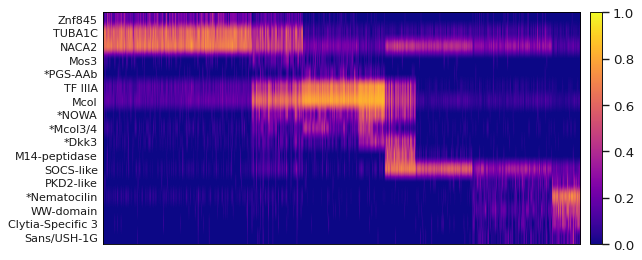

In [ ]:

sc.set_figure_params(scanpy=True, fontsize=12)
sc.pl.heatmap(orderCnido, labelsCnido, groupby=None, 
              show_gene_labels=True,use_raw=False,standard_scale='var',
              interpolation='antialiased',cmap='plasma',swap_axes=True,gene_symbols='names',figsize=(8,4),
              save='cnido_gauss_BigLinTimeGenes.pdf')

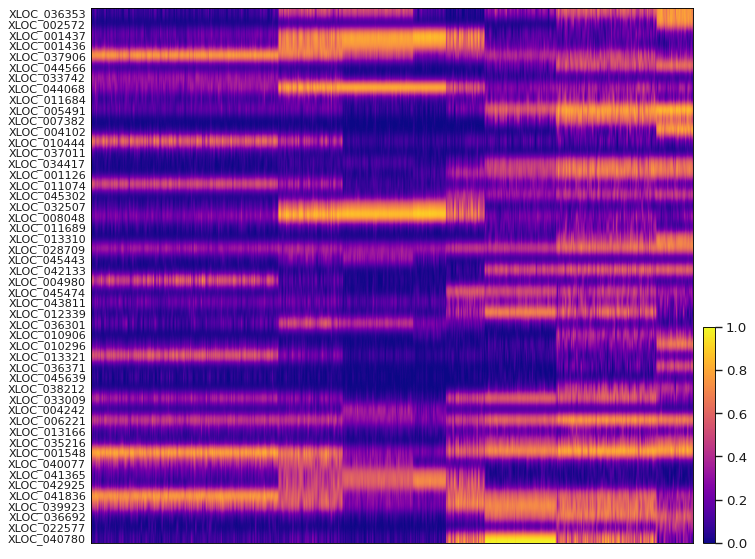

In [ ]:
orderCnido = orderTimeClus(cnido)
sc.set_figure_params(scanpy=True, fontsize=12)
sc.pl.heatmap(orderCnido, list(cnido_gene_res.Genes[0:50]), groupby=None, 
              show_gene_labels=True,use_raw=False,standard_scale='obs',
              interpolation='gaussian',cmap='plasma',swap_axes=True,
              save='all_cnido_gauss_BigLinTimeGenes.pdf')

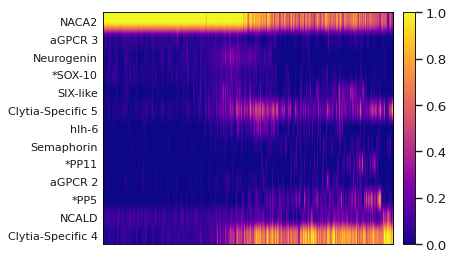

In [ ]:

sc.set_figure_params(scanpy=True, fontsize=12)
sc.pl.heatmap(orderNeuro, labelsNeuro, groupby=None, 
              show_gene_labels=True,use_raw=False,standard_scale='obs',
              interpolation='antialiased',resample= True,filterrad =.04,filterNorm =  True, cmap='plasma',swap_axes=True,gene_symbols='names',figsize=(5,4),
              save='neuro_gauss_BigLinTimeGenes.pdf') #Change normalization (z-score), don't need relative expression here

In [ ]:
orderNeuro.var_names

Index(['XLOC_045293', 'XLOC_010226', 'XLOC_018937', 'XLOC_034623',
       'XLOC_030920', 'XLOC_012560', 'XLOC_030920', 'XLOC_038831',
       'XLOC_019434', 'XLOC_002941', 'XLOC_017097'],
      dtype='object')

In [ ]:
from sklearn.preprocessing import MinMaxScaler
X = orderNeuro.X.toarray()
min_max_scaler = MinMaxScaler()
scaled = min_max_scaler.fit_transform(X)

In [ ]:
d = pd.DataFrame()

geneN = ['XLOC_045293', 'XLOC_018937','XLOC_030920','XLOC_034623','XLOC_019434']
geneVals = []
geneNames = []
cells = []
for i in geneN:
  g = np.ravel(scaled[:,orderNeuro.var_names.isin([i])], order='C').tolist()
  geneVals += g
  geneNames += [allGenes[i]]*len(g)

  cells += range(0,len(g))

d['name'] = geneNames
d['expr'] = geneVals
d['cells'] = np.array(cells)/len(g)



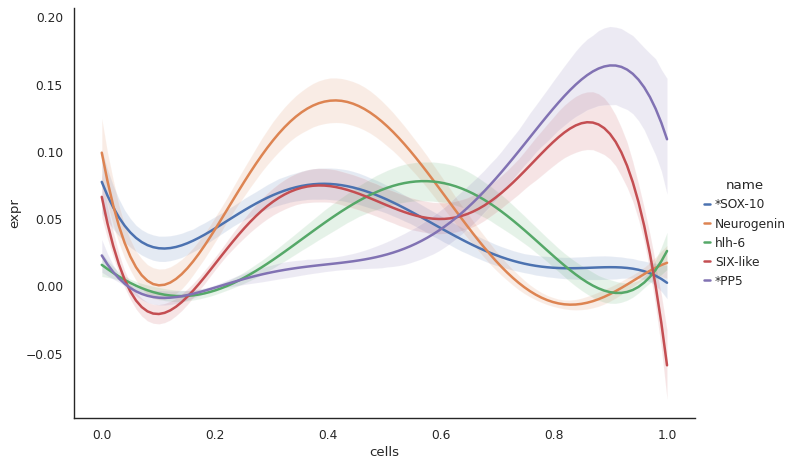

In [ ]:
sns.set(style='white')
p = sns.lmplot('cells', 'expr', data=d, hue='name', order=5, truncate=True,scatter=False,height=6, aspect=1.5)
p.savefig('regr.pdf')

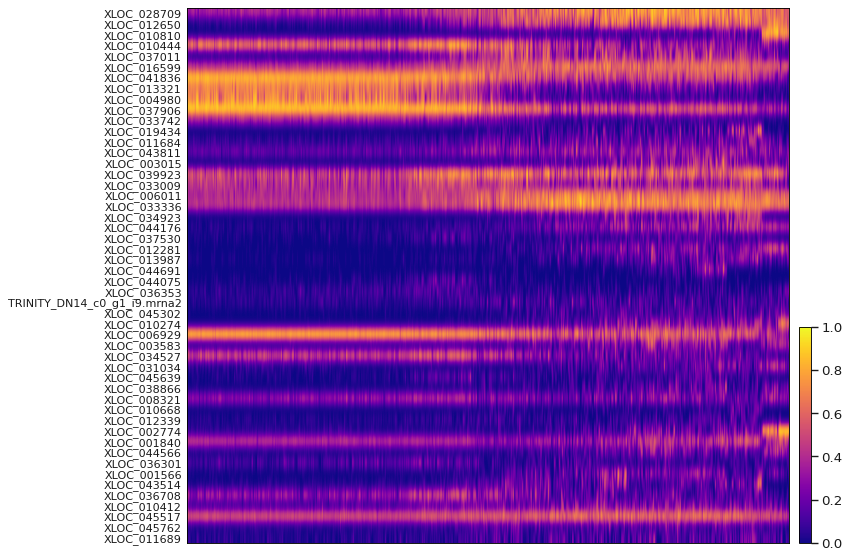

In [ ]:
orderNeuro = orderTime(neuro)
sc.set_figure_params(scanpy=True, fontsize=12)
sc.pl.heatmap(orderNeuro, list(neuro_gene_res.Genes[0:50]), groupby=None, 
              show_gene_labels=True,use_raw=False,standard_scale='obs',
              interpolation='gaussian',cmap='plasma',swap_axes=True,
              save='all_neuro_gauss_BigLinTimeGenes.pdf')